In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

def drawGetRequests(market_log, market_cpu, ax, title):
    # Konwersja kolumny 'timestamp' na typ datetime z określonym formatem
    market_log['timestamp'] = pd.to_datetime(market_log['timestamp'], format='ISO8601')
    market_cpu['timestamp'] = pd.to_datetime(market_cpu['timestamp'], format='ISO8601')

    # Łączenie danych na podstawie 'timestamp'
    merged_data = pd.merge_asof(market_log.sort_values('timestamp'), 
                                market_cpu.sort_values('timestamp'), 
                                on='timestamp')

    # Podział na żądania GET
    get_requests = merged_data[merged_data['apiMethod'] == 'GET']

    # Rysowanie na podanym subplotcie
    ax.plot(get_requests['timestamp'], get_requests['apiTime'], alpha=0.6)
    ax.tick_params(axis='y', labelcolor='blue')
    ax.set_xlabel('Time')
    ax.set_ylabel('API Response Time (ms)', color='blue')


    ax2 = ax.twinx()
    ax2.plot(get_requests['timestamp'], get_requests['cpuUsage'], color='red', alpha=0.6)
    ax2.set_ylabel('CPU Usage (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    ax.set_title(title)

def drawPostRequests(market_log, market_cpu, ax, title):
    # Konwersja kolumny 'timestamp' na typ datetime z określonym formatem
    market_log['timestamp'] = pd.to_datetime(market_log['timestamp'], format='ISO8601')
    market_cpu['timestamp'] = pd.to_datetime(market_cpu['timestamp'], format='ISO8601')

    # Łączenie danych na podstawie 'timestamp'
    merged_data = pd.merge_asof(market_log.sort_values('timestamp'), 
                                market_cpu.sort_values('timestamp'), 
                                on='timestamp')

    # Podział na żądania POST
    post_requests = merged_data[merged_data['apiMethod'] == 'POST']

    # Rysowanie na podanym subplotcie
    ax.plot(post_requests['timestamp'], post_requests['apiTime'], alpha=0.6)
    ax.tick_params(axis='y', labelcolor='blue')

    ax2 = ax.twinx()
    ax2.plot(post_requests['timestamp'], post_requests['cpuUsage'], color='red', alpha=0.6)
    ax2.tick_params(axis='y', labelcolor='red')

    ax.set_title(title)



In [2]:
def drawTimesOnOnePlot(trade_log, ax, title):
    # Konwersja kolumny 'timestamp' na typ datetime z określonym formatem
    trade_log['timestamp'] = pd.to_datetime(trade_log['timestamp'], format='ISO8601')
    
    # Resampling co 30 sekund, obliczanie średnich dla odpowiednich kolumn
    trade_log_resampled = trade_log.resample('15S', on='timestamp').mean(numeric_only=True).reset_index()

    # Rysowanie na podanym subplotcie
    if "Api Time" in title:
        ax.plot(trade_log_resampled['timestamp'], trade_log_resampled['apiTime'], label='API Time', color='blue', alpha=0.6)
    elif "Application Time" in title:
        ax.plot(trade_log_resampled['timestamp'], trade_log_resampled['applicationTime'], label='Application Time', color='green', alpha=0.6)
    elif "Database Time" in title:
        ax.plot(trade_log_resampled['timestamp'], trade_log_resampled['databaseTime'], label='Database Time', color='orange', alpha=0.6)
    else:
        ax.plot(trade_log_resampled['timestamp'], trade_log_resampled['apiTime'], label='API Time', color='blue', alpha=0.6)
        ax.plot(trade_log_resampled['timestamp'], trade_log_resampled['applicationTime'], label='Application Time', color='green', alpha=0.6)
        ax.plot(trade_log_resampled['timestamp'], trade_log_resampled['databaseTime'], label='Database Time', color='orange', alpha=0.6)

    ax.set_xlabel('Time')
    ax.set_ylabel('Time (ms)')
    ax.tick_params(axis='y')

    ax.set_title(title)
    ax.legend()

In [3]:
def drawApplicationAndDatabaseTime(market_log, market_cpu, ax, title):
    # Konwersja kolumny 'timestamp' na typ datetime
    market_log['timestamp'] = pd.to_datetime(market_log['timestamp'], format='ISO8601')
    market_cpu['timestamp'] = pd.to_datetime(market_cpu['timestamp'], format='ISO8601')

    # Resampling co 5 sekund, obliczanie średnich tylko dla kolumn numerycznych
    market_log_resampled = market_log.resample('15S', on='timestamp').mean(numeric_only=True).reset_index()
    market_cpu_resampled = market_cpu.resample('15S', on='timestamp').mean(numeric_only=True).reset_index()

    # Usuwanie wierszy z NaN po połączeniu danych
    merged_data = pd.merge_asof(market_log_resampled.sort_values('timestamp'), 
                                market_cpu_resampled.sort_values('timestamp'), 
                                on='timestamp').dropna()

    # Sprawdzenie, czy w danych są wartości do narysowania
    if merged_data.empty:
        print("Brak danych do narysowania wykresu.")
        return

    # Wykres dla uśrednionego applicationTime w stosunku do cpuUsage
    ax.set_xlabel('Time')
    ax.set_ylabel('Time (ms)', color='blue')
    ax.plot(merged_data['timestamp'], merged_data['applicationTime'], color='blue', label='Average Application Time (ms)')
    ax.tick_params(axis='y', labelcolor='blue')

    ax2 = ax.twinx()
    ax2.set_ylabel('CPU Usage (%)', color='red')
    ax2.plot(merged_data['timestamp'], merged_data['cpuUsage'], color='red', label='Average CPU Usage (%)', alpha=0.7)
    ax2.tick_params(axis='y', labelcolor='red')

    ax.set_title(title)
    # ax.legend(loc='upper left')
    # ax2.legend(loc='upper right')

In [4]:
def drawOffersAndCpu(trade_log, trade_cpu):
  # Konwersja kolumny 'timestamp' na typ datetime
  trade_log['timestamp'] = pd.to_datetime(trade_log['timestamp'], format='ISO8601')
  trade_cpu['timestamp'] = pd.to_datetime(trade_cpu['timestamp'], format='ISO8601')

  # Sumowanie liczby przetworzonych ofert (kupna + sprzedaży)
  trade_log['totalOffers'] = trade_log['numberOfSellOffers'] + trade_log['numberOfBuyOffers']

  # Sprawdzenie, czy kolumna 'replicaId' istnieje w obu DataFrame'ach
  if 'replicaId' in trade_log.columns:
      # Łączenie danych na podstawie 'timestamp' i 'replicaId'
      merged_data = pd.merge_asof(trade_log.sort_values('timestamp'), 
                                  trade_cpu.sort_values('timestamp'), 
                                  on='timestamp', 
                                  by='replicaId')
  else:
      # Łączenie danych tylko na podstawie 'timestamp'
      merged_data = pd.merge_asof(trade_log.sort_values('timestamp'), 
                                  trade_cpu.sort_values('timestamp'), 
                                  on='timestamp')

  # Podział na różne repliki (jeśli 'replicaId' istnieje)
  if 'replicaId' in merged_data.columns:
      replicas = merged_data['replicaId'].unique()
  else:
      replicas = [None]  # Brak replik

  # Tworzenie wykresów dla każdej repliki
  for replica in replicas:
      if replica is not None:
          replica_data = merged_data[merged_data['replicaId'] == replica]
          title = f'Replica {replica}: Total Processed Offers and CPU Usage Over Time'
      else:
          replica_data = merged_data
          title = 'Total Processed Offers and CPU Usage Over Time'

      fig, ax1 = plt.subplots(figsize=(12, 6))

      ax1.set_xlabel('Time')
      ax1.set_ylabel('Total Processed Offers', color='blue')
      ax1.plot(replica_data['timestamp'], replica_data['totalOffers'], color='blue', label='Total Processed Offers')
      ax1.tick_params(axis='y', labelcolor='blue')

      ax2 = ax1.twinx()
      ax2.set_ylabel('CPU Usage (%)', color='red')
      ax2.plot(replica_data['timestamp'], replica_data['cpuUsage'], color='red', label='CPU Usage (%)', alpha=0.7)
      ax2.tick_params(axis='y', labelcolor='red')

      plt.title(title)
      fig.tight_layout()
      plt.show()

In [5]:
def drawOffersAndApiTime(trade_log, market_log, ax, title):
    # Konwersja kolumny 'timestamp' na typ datetime
    trade_log['timestamp'] = pd.to_datetime(trade_log['timestamp'], errors='coerce', format='ISO8601')
    market_log['timestamp'] = pd.to_datetime(market_log['timestamp'], errors='coerce', format='ISO8601')

    # Drop rows with NaT in timestamp after conversion
    trade_log = trade_log.dropna(subset=['timestamp'])
    market_log = market_log.dropna(subset=['timestamp'])

    # Sumowanie liczby przetworzonych ofert (kupna + sprzedaży)
    trade_log['totalOffers'] = trade_log['numberOfSellOffers'] + trade_log['numberOfBuyOffers']

    # Uśrednianie apiTime z 15-sekundowych interwałów
    numeric_cols = market_log.select_dtypes(include=['number']).columns
    market_log_resampled = market_log.set_index('timestamp')[numeric_cols].resample('15S').mean().reset_index()

    # Łączenie danych na podstawie 'timestamp'
    merged_data = pd.merge_asof(trade_log.sort_values('timestamp'), 
                                market_log_resampled.sort_values('timestamp'), 
                                on='timestamp')

    # Wykres dla liczby przetworzonych ofert
    ax.set_xlabel('Time')
    ax.set_ylabel('Total Processed Offers', color='blue')
    ax.plot(merged_data['timestamp'], merged_data['totalOffers'], color='blue', label='Total Processed Offers')
    ax.tick_params(axis='y', labelcolor='blue')

    # Druga oś Y dla uśrednionego czasu API
    ax2 = ax.twinx()
    ax2.set_ylabel('Average API Time (ms) - 15s intervals', color='green')
    ax2.plot(merged_data['timestamp'], merged_data['apiTime'], color='green', label='Average API Time (ms)', alpha=0.6)
    ax2.tick_params(axis='y', labelcolor='green')

    # Ustawienie tytułu i legendy
    ax.set_title(title)

In [6]:
def drawTimesAndOffers(trade_log, ax, title):
    # Konwersja kolumny 'timestamp' na typ datetime
    trade_log['timestamp'] = pd.to_datetime(trade_log['timestamp'], format='ISO8601')

    # Sumowanie liczby przetworzonych ofert (kupna + sprzedaży)
    trade_log['totalOffers'] = trade_log['numberOfSellOffers'] + trade_log['numberOfBuyOffers']

    ax.set_xlabel('Time')
    ax.set_ylabel('Time (ms)', color='blue')
    
    # Wykres dla applicationTime
    ax.plot(trade_log['timestamp'], trade_log['applicationTime'], label='Application Time', color='blue')
    
    # Wykres dla databaseTime
    ax.plot(trade_log['timestamp'], trade_log['databaseTime'], label='Database Time', color='green')

    ax.tick_params(axis='y', labelcolor='blue')

    ax2 = ax.twinx()
    ax2.set_ylabel('Total Processed Offers', color='red')
    
    # Wykres dla totalOffers
    ax2.plot(trade_log['timestamp'], trade_log['totalOffers'], label='Total Processed Offers', color='red', alpha=0.7)
    ax2.tick_params(axis='y', labelcolor='red')

    # Dodanie legendy
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

    ax.set_title(title)

In [7]:
def drawTimesAndCpu(trade_log, trade_cpu):
    # Konwersja kolumny 'timestamp' na typ datetime
    trade_log['timestamp'] = pd.to_datetime(trade_log['timestamp'], format='ISO8601')
    trade_cpu['timestamp'] = pd.to_datetime(trade_cpu['timestamp'], format='ISO8601')

    # Łączenie danych na podstawie 'timestamp'
    merged_data = pd.merge_asof(trade_log.sort_values('timestamp'), 
                                trade_cpu.sort_values('timestamp'), 
                                on='timestamp')

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Time (ms)', color='blue')
    
    # Wykres dla applicationTime
    ax1.plot(merged_data['timestamp'], merged_data['applicationTime'], label='Application Time', color='blue')
    
    # Wykres dla databaseTime
    ax1.plot(merged_data['timestamp'], merged_data['databaseTime'], label='Database Time', color='green')

    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('CPU Usage (%)', color='red')
    
    # Wykres dla cpuUsage
    ax2.plot(merged_data['timestamp'], merged_data['cpuUsage'], label='CPU Usage (%)', color='red', alpha=0.7)
    ax2.tick_params(axis='y', labelcolor='red')

    # Dodanie legendy
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title('Application Time, Database Time, and CPU Usage Over Time')
    fig.tight_layout()
    plt.show()


In [8]:
def drawAverageResponseTime(complete_market_log):
  # Group data by API method and endpoints, calculate average response times
  api_performance = complete_market_log.groupby(['apiMethod', 'endpointUrl']).agg({
      'applicationTime': 'mean',
      'databaseTime': 'mean',
      'apiTime': 'mean'
  }).reset_index()

  # Plot response times for different API methods
  plt.figure(figsize=(14, 7))
  sns.barplot(x='apiMethod', y='applicationTime', hue='endpointUrl', data=api_performance)
  plt.title('Average Response Time for Different API Methods and Endpoints')
  plt.xlabel('API Method')
  plt.ylabel('Average Response Time (ms)')
  plt.xticks(rotation=45)
  plt.legend(title='Endpoint URL')
  plt.show()

In [9]:
def drawAverageCpuReplic(trade_cpu, ax, title):
    # Grupowanie danych według replicaId, obliczanie średniego zużycia CPU i pamięci
    replica_performance = trade_cpu.groupby('replicaId').agg({
        'cpuUsage': 'mean',
        'memoryUsage': 'mean'
    }).reset_index()

    # Rysowanie wykresu dla średniego zużycia CPU i pamięci dla różnych replik
    sns.barplot(x='replicaId', y='cpuUsage', data=replica_performance, color='b', label='CPU Usage', ax=ax)
    sns.barplot(x='replicaId', y='memoryUsage', data=replica_performance, color='r', label='Memory Usage', ax=ax, alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('Replica ID')
    ax.set_ylabel('Average Usage (%)')
    ax.legend(title='Usage Type')

In [10]:
def trafficCpu(traffic_cpu):
  traffic_cpu['timestamp'] = pd.to_datetime(traffic_cpu['timestamp'], format='ISO8601')

  # Plot trends of CPU and memory usage over time
  plt.figure(figsize=(14, 7))
  plt.plot(traffic_cpu['timestamp'], traffic_cpu['cpuUsage'], label='CPU Usage')
  plt.plot(traffic_cpu['timestamp'], traffic_cpu['memoryUsage'], label='Memory Usage')
  plt.title('Trends in CPU and Memory Usage Over Time')
  plt.xlabel('Timestamp')
  plt.ylabel('Usage (%)')
  plt.legend()
  plt.xticks(rotation=45)
  plt.show()

In [11]:
def hisMarketCpu(market_cpu, ax, title):
    # Rysowanie histogramu dla CPU usage na podanym subplotcie
    ax.hist(market_cpu['cpuUsage'], bins=30, color='blue', edgecolor='black')
    ax.set_title(f'Distribution of CPU Usage - {title}')
    ax.set_xlabel('CPU Usage (%)')
    ax.set_ylabel('Frequency')

def hisMarketRam(market_cpu, ax, title):
    # Rysowanie histogramu dla Memory usage na podanym subplotcie
    ax.hist(market_cpu['memoryUsage'], bins=30, color='green', edgecolor='black')
    ax.set_title(f'Distribution of Memory Usage - {title}')
    ax.set_xlabel('Memory Usage (%)')
    ax.set_ylabel('Frequency')

In [12]:
def mapCpuMem(traffic_cpu):
  # Scatter plot for CPU usage vs Memory usage
  plt.figure(figsize=(10, 6))
  plt.scatter(traffic_cpu['cpuUsage'], traffic_cpu['memoryUsage'], alpha=0.5)
  plt.title('CPU Usage vs Memory Usage')
  plt.xlabel('CPU Usage (%)')
  plt.ylabel('Memory Usage (%)')
  plt.show()

In [13]:
def offersPerMin(trade_log, market_cpu, ax, title):
    # Konwersja kolumny 'timestamp' na datetime w obu zestawach danych
    trade_log['timestamp'] = pd.to_datetime(trade_log['timestamp'], format='ISO8601')
    market_cpu['timestamp'] = pd.to_datetime(market_cpu['timestamp'], format='ISO8601')

    # Resampling (agregowanie) danych na minuty
    trade_log_minute = trade_log.resample('T', on='timestamp').sum().reset_index()
    market_cpu_minute = market_cpu.resample('T', on='timestamp').mean().reset_index()

    # Łączenie danych na podstawie kolumny 'timestamp'
    merged_data_minute = pd.merge(trade_log_minute, market_cpu_minute, on='timestamp')

    # Rysowanie wykresu zużycia CPU na pierwszej osi Y
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('CPU Usage (%)', color='blue')
    line1, = ax.plot(merged_data_minute['timestamp'], merged_data_minute['cpuUsage'], color='blue', label='CPU Usage')
    ax.tick_params(axis='y', labelcolor='blue')

    # Tworzenie drugiej osi Y dla liczby ofert kupna i sprzedaży
    ax2 = ax.twinx()
    ax2.set_ylabel('Number of Offers', color='green')
    line2, = ax2.plot(merged_data_minute['timestamp'], merged_data_minute['numberOfBuyOffers'], color='orange', label='Buy Offers')
    line3, = ax2.plot(merged_data_minute['timestamp'], merged_data_minute['numberOfSellOffers'], color='red', label='Sell Offers')
    ax2.tick_params(axis='y', labelcolor='green')

    # Ustawienie tytułu dla danego subplotu
    ax.set_title(title)

    # Zbieranie uchwytów i etykiet z obu osi do jednej legendy
    lines = [line1, line2, line3]
    labels = [line.get_label() for line in lines]
    ax.legend(lines, labels, loc='lower left')

In [14]:
def load_data_from_subdirectories(base_dir):
    data = []
    test_paths = []
    
    for root, dirs, files in os.walk(base_dir):
        complete_market_log_csv_path = os.path.join(root, 'complete_market_log_csv.csv')
        market_cpu_path = os.path.join(root, 'market_cpu.csv')
        market_log_path = os.path.join(root, 'market_log.csv')
        traffic_cpu_path = os.path.join(root, 'traffic_cpu.csv')
        sum_trade_log_path = os.path.join(root, 'sum_trade_log.csv')
        trade_cpu_path = os.path.join(root, 'trade_cpu.csv')
        trade_log_path = os.path.join(root, 'trade_log.csv')
        
        # Sprawdzamy czy wszystkie pliki istnieją
        if all(os.path.exists(path) for path in [complete_market_log_csv_path, market_cpu_path, traffic_cpu_path, sum_trade_log_path, trade_cpu_path, market_log_path, trade_log_path]):
            # Wczytujemy pliki CSV do DataFrame
            complete_market_log_csv = pd.read_csv(complete_market_log_csv_path)
            market_cpu = pd.read_csv(market_cpu_path)
            market_log = pd.read_csv(market_log_path)
            traffic_cpu = pd.read_csv(traffic_cpu_path)
            sum_trade_log = pd.read_csv(sum_trade_log_path)
            trade_cpu = pd.read_csv(trade_cpu_path)
            trade_log = pd.read_csv(trade_log_path)
            
            data.append({
                'complete_market_log_csv': complete_market_log_csv,
                'market_cpu': market_cpu,
                'market_log': market_log,
                'traffic_cpu': traffic_cpu,
                'sum_trade_log': sum_trade_log,
                'trade_cpu': trade_cpu,
                'trade_log': trade_log
            })
            
            # Dodajemy ścieżkę podkatalogu do listy test_paths
            relative_path = os.path.relpath(root, base_dir)
            test_paths.append(relative_path)
            
            print(f"Loaded data from {root} successfully.")
    
    return data, test_paths


def draw_all_subplots(all_data):
    # Figura dla GET Requests
    fig_get, axes_get = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    # Rysowanie dla GET Requests
    for idx in range(4):
        ax = axes_get[idx // 2, idx % 2]  # Kolejne subplots w siatce 2x2
        if idx < len(all_data):
            drawGetRequests(all_data[idx]['complete_market_log_csv'], all_data[idx]['market_cpu'], ax, test_paths[idx])

    # Wyświetlenie wykresów GET
    fig_get.suptitle('GET Requests: API Response Time and CPU Usage Over Time')
    plt.show()

    # Figura dla POST Requests
    fig_post, axes_post = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    # Rysowanie dla POST Requests
    for idx in range(4):
        ax = axes_post[idx // 2, idx % 2]  # Kolejne subplots w siatce 2x2
        if idx < len(all_data):
            drawPostRequests(all_data[idx]['complete_market_log_csv'], all_data[idx]['market_cpu'], ax, test_paths[idx])

    fig_post.suptitle('POST Requests: API Response Time and CPU Usage Over Time')
    plt.show()

    fig_post, axes_post = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    
    for idx in range(4):
        ax = axes_post[idx // 2, idx % 2]  # Kolejne subplots w siatce 2x2
        if idx < len(all_data):
            drawApplicationAndDatabaseTime(all_data[idx]['market_log'], all_data[idx]['market_cpu'], ax, test_paths[idx])

    # Wyświetlenie wykresów POST
    fig_post.suptitle('Average Market Application Time and CPU Usage Over Time (15-second intervals)')
    plt.show()


    fig_post, axes_post = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    
    for idx in range(4):
        ax = axes_post[idx // 2, idx % 2]  # Kolejne subplots w siatce 2x2
        if idx < len(all_data):
            drawTimesAndOffers(all_data[idx]['sum_trade_log'], ax, test_paths[idx])

    # Wyświetlenie wykresów POST
    fig_post.suptitle('Application Time, Database Time, and Total Processed Offers Over Time')
    plt.show()

    fig_post, axes_post = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    for idx in range(4):
        ax = axes_post[idx // 2, idx % 2]  # Kolejne subplots w siatce 2x2
        if idx < len(all_data):
            drawTimesOnOnePlot(all_data[idx]['complete_market_log_csv'], ax, test_paths[idx])

    # Wyświetlenie wykresów POST
    fig_post.suptitle('Application Time, Database Time, and Total Processed Offers Over Time')
    plt.show()
    
    for idx in range(4):
        fig_post, axes_post = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))
        plt.subplots_adjust(hspace=0.4, wspace=0.4)
        
        drawTimesOnOnePlot(all_data[idx]['complete_market_log_csv'], axes_post[0], "Api Time (15-second intervals)")
        drawTimesOnOnePlot(all_data[idx]['complete_market_log_csv'], axes_post[1], "Application Time (15-second intervals)")
        drawTimesOnOnePlot(all_data[idx]['complete_market_log_csv'], axes_post[2], "Database Time (15-second intervals)")

        fig_post.suptitle(test_paths[idx])
        plt.show()

    for idx in range(4):
        fig_post, axes_post = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))
        plt.subplots_adjust(hspace=0.4, wspace=0.4)
        
        hisMarketCpu(all_data[idx]['traffic_cpu'], axes_post[0, 0], "Traffic CPU")
        hisMarketRam(all_data[idx]['traffic_cpu'], axes_post[0, 1], "Traffic RAM")
        hisMarketCpu(all_data[idx]['market_cpu'], axes_post[1, 0], "Market CPU")
        hisMarketRam(all_data[idx]['market_cpu'], axes_post[1, 1], "Market RAM")
        hisMarketCpu(all_data[idx]['trade_cpu'], axes_post[2, 0], "Trade CPU")
        hisMarketRam(all_data[idx]['trade_cpu'], axes_post[2, 1], "Trade RAM")

        fig_post.suptitle(test_paths[idx])
        plt.show()

    fig_post, axes_post = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    for idx in range(4):
        ax = axes_post[idx // 2, idx % 2]  # Kolejne subplots w siatce 2x2
        if idx < len(all_data):
            drawAverageCpuReplic(all_data[idx]['trade_cpu'], ax, test_paths[idx])

    # Wyświetlenie wykresów POST
    fig_post.suptitle('Average CPU and Memory Usage for Different Replicas')
    plt.show()


    fig_post, axes_post = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    for idx in range(4):
        ax = axes_post[idx // 2, idx % 2]  # Kolejne subplots w siatce 2x2
        if idx < len(all_data):
            offersPerMin(all_data[idx]['trade_log'], all_data[idx]['market_cpu'] , ax, test_paths[idx])

    # Wyświetlenie wykresów POST
    fig_post.suptitle('CPU Usage (Market) vs Number of Buy and Sell Offers Processed Per Minute')
    plt.show()

    fig_post, axes_post = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    for idx in range(4):
        if idx < len(all_data):
            ax = axes_post[idx // 2, idx % 2]  # Kolejne subplots w siatce 2x2
            drawOffersAndApiTime(all_data[idx]['sum_trade_log'], all_data[idx]['complete_market_log_csv'], ax, test_paths[idx])

    # Ustawienie tytułu całego wykresu
    fig_post.suptitle('Total Processed Offers and Average API Time (15s intervals)')
    plt.show()


# Test 1

Loaded data from test1\1 10 200 500 4 500 100 successfully.
Loaded data from test1\10 1 200 500 4 500 100 successfully.
Loaded data from test1\2 5 200 500 4 500 100 successfully.
Loaded data from test1\5 2 200 500 4 500 100 successfully.


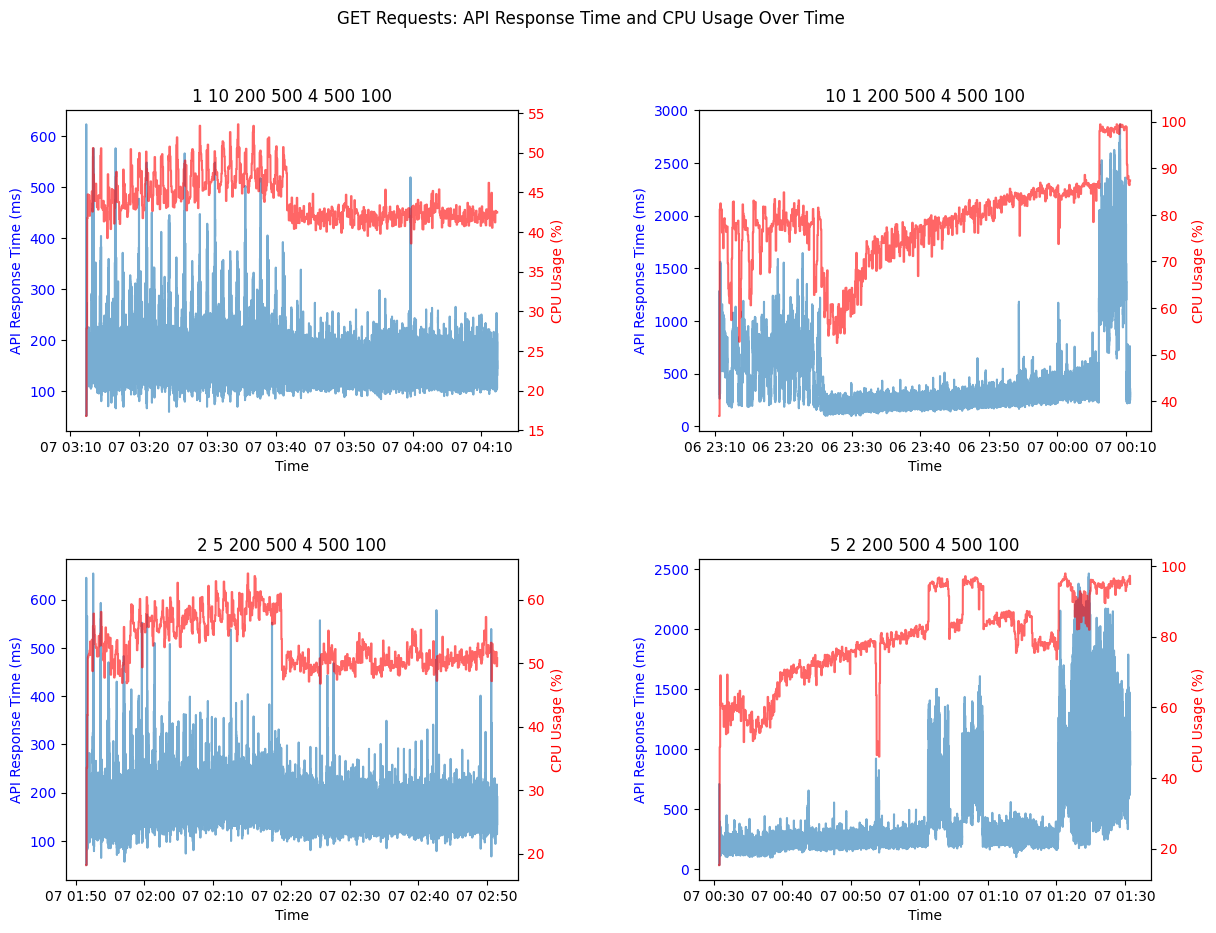

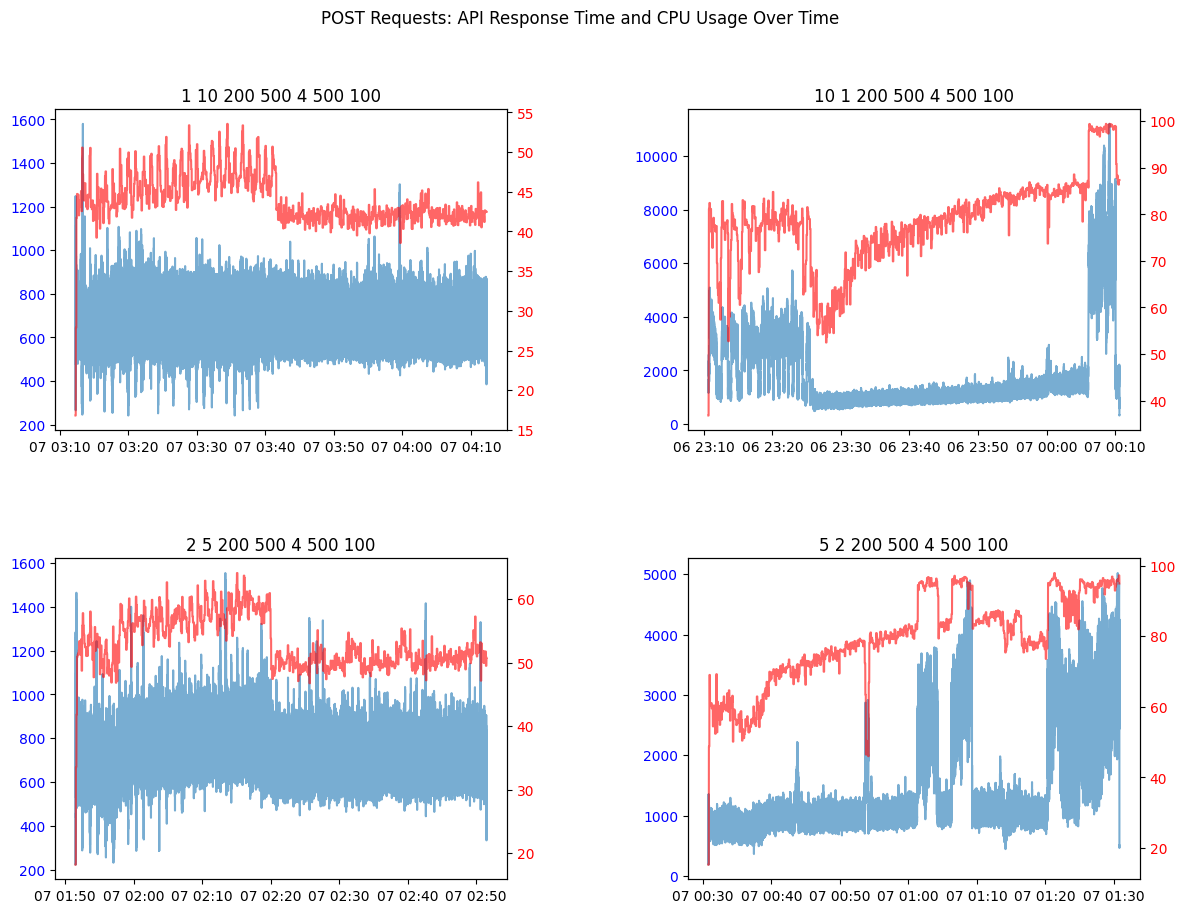

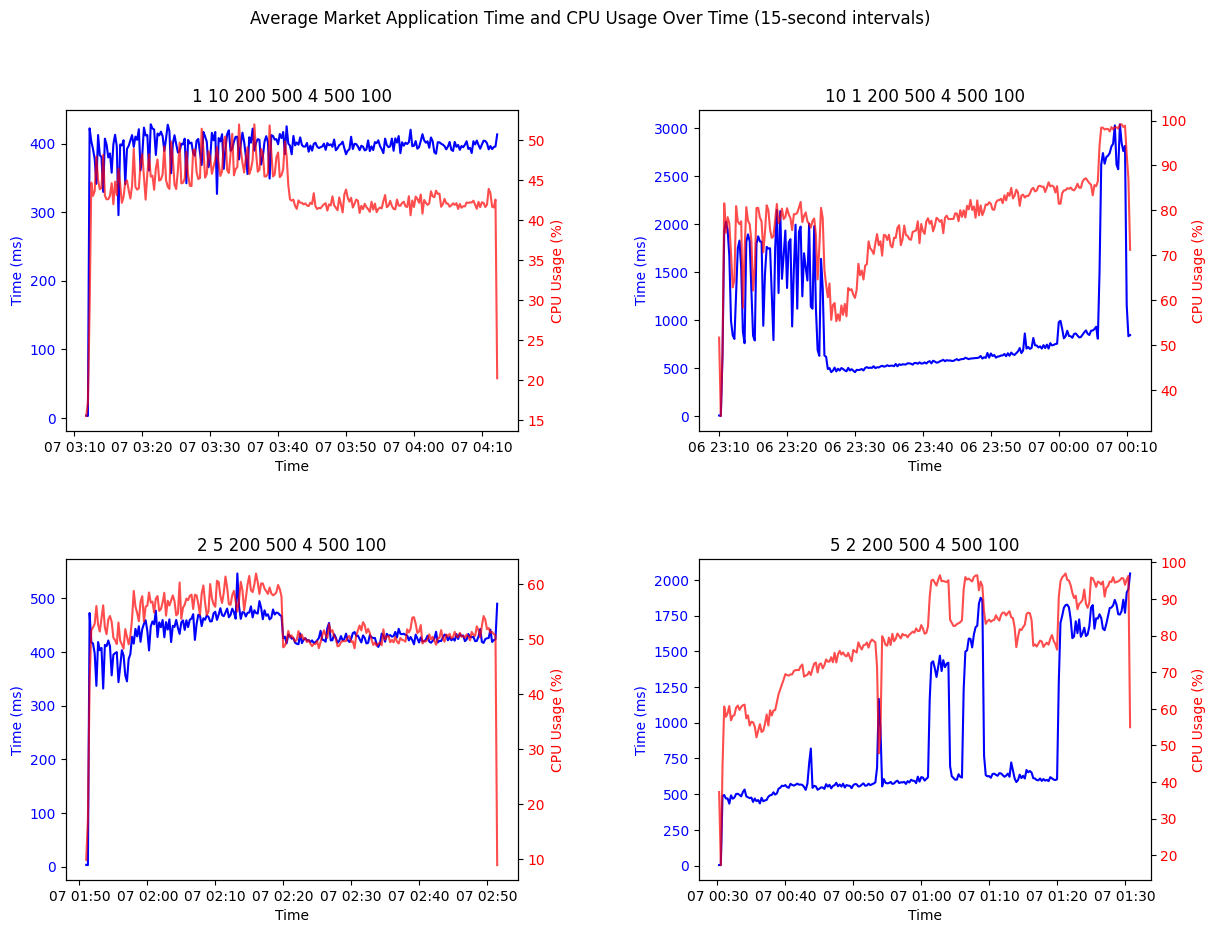

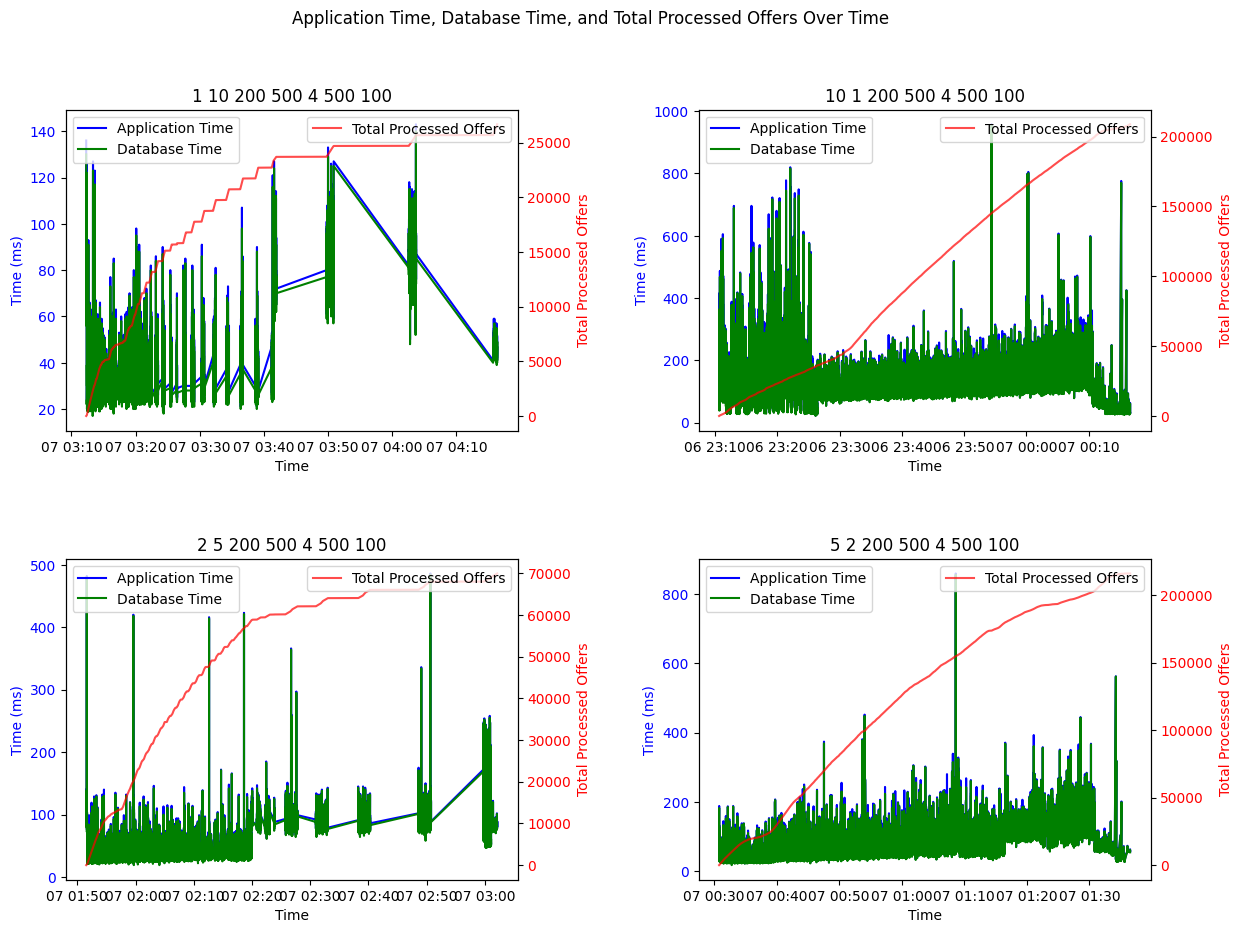

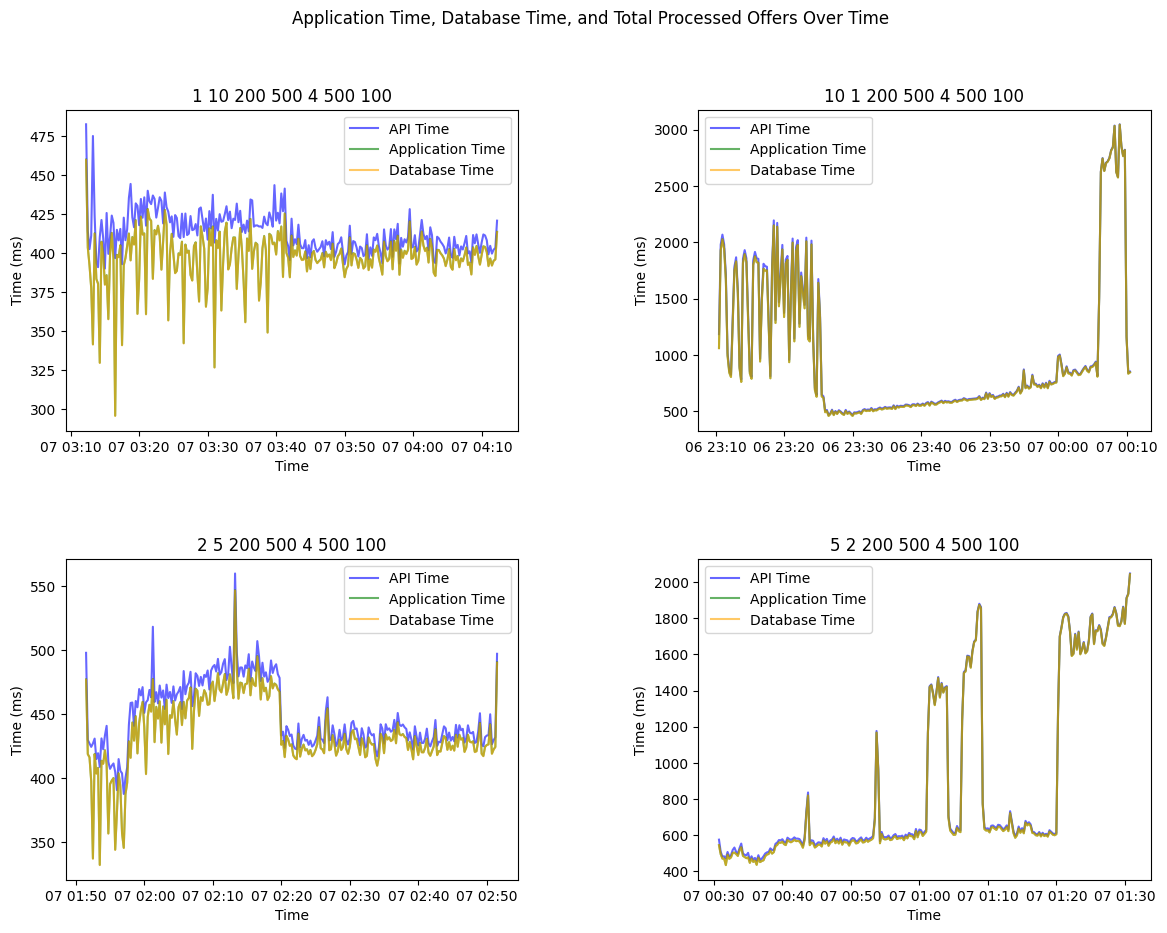

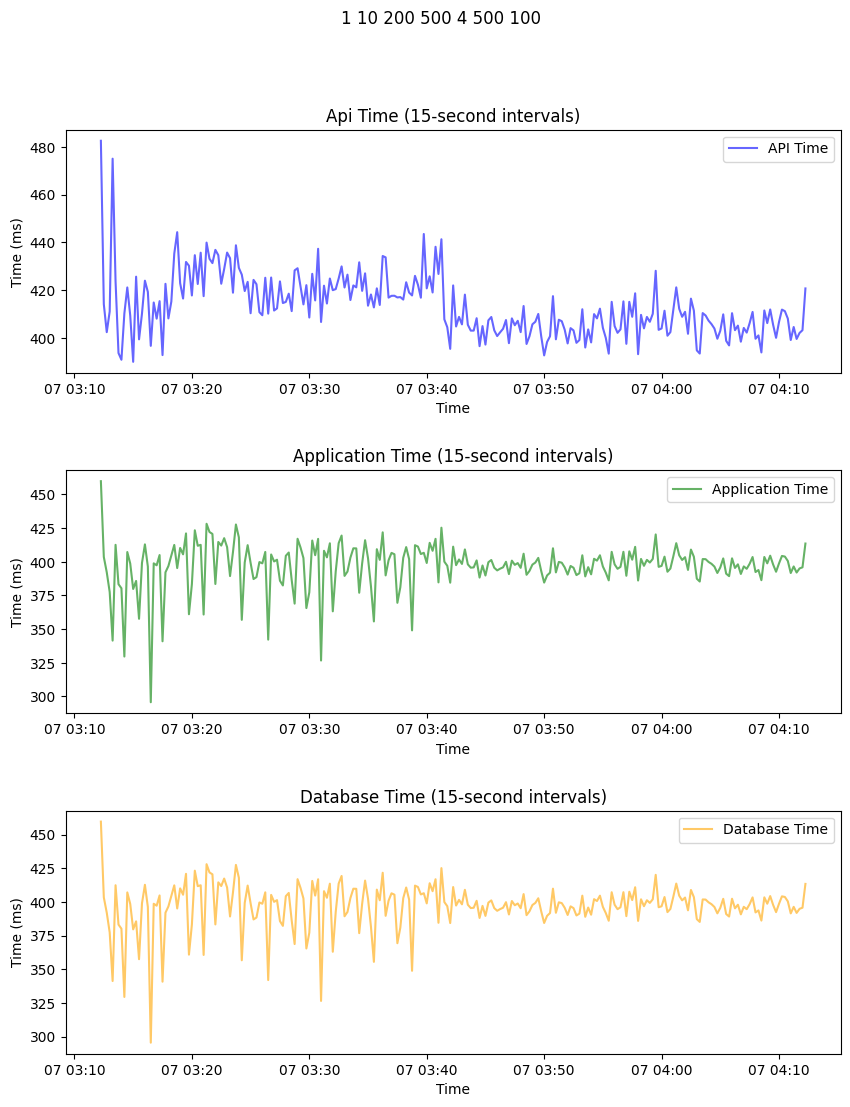

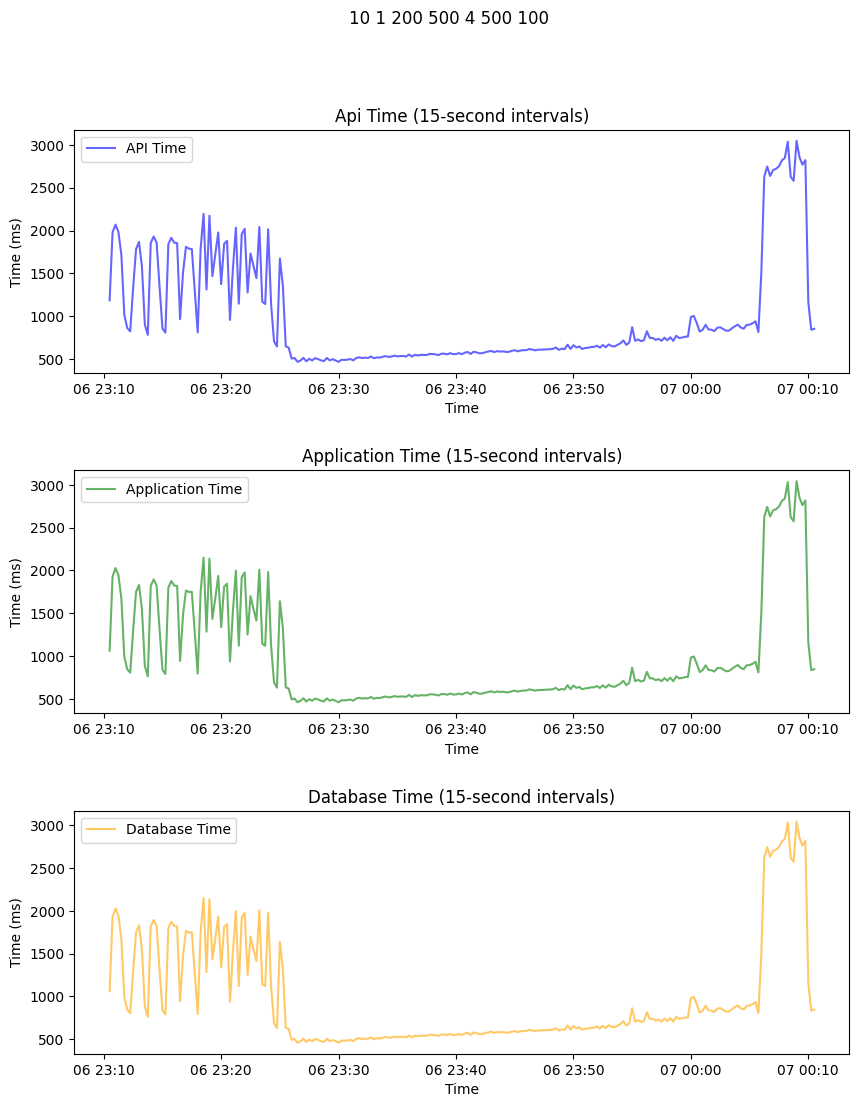

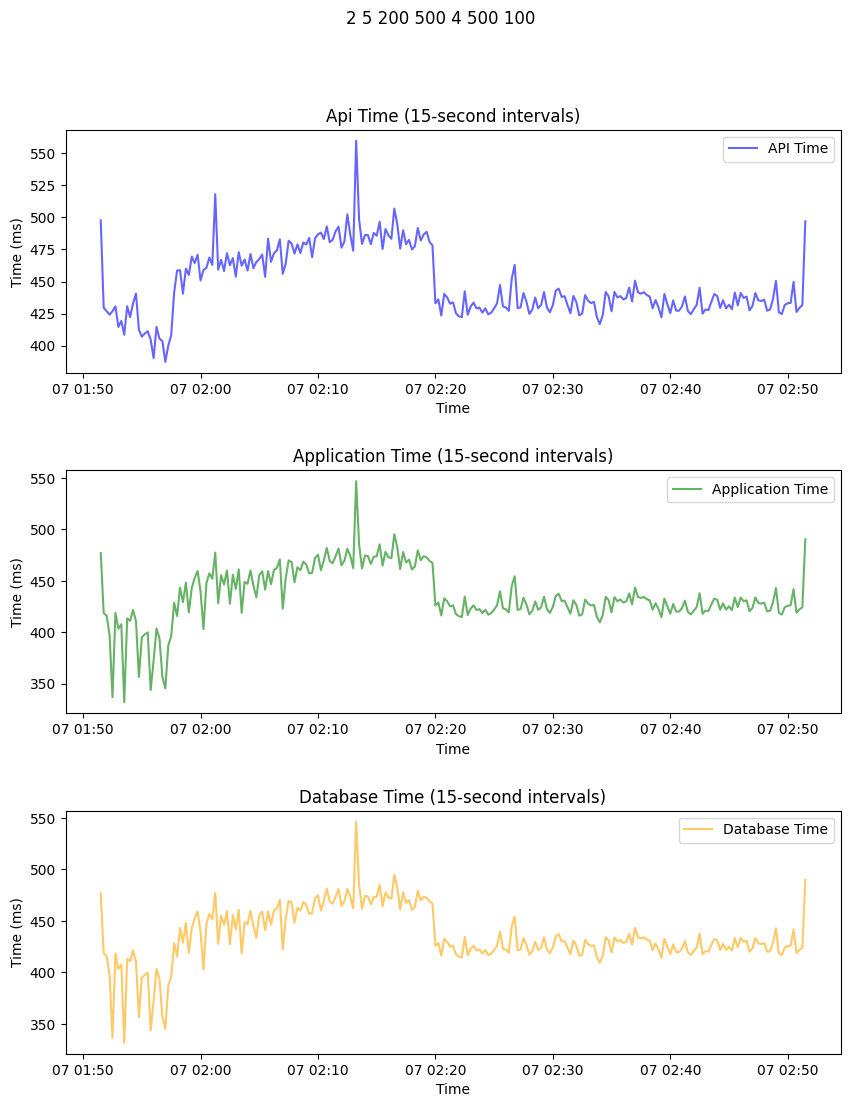

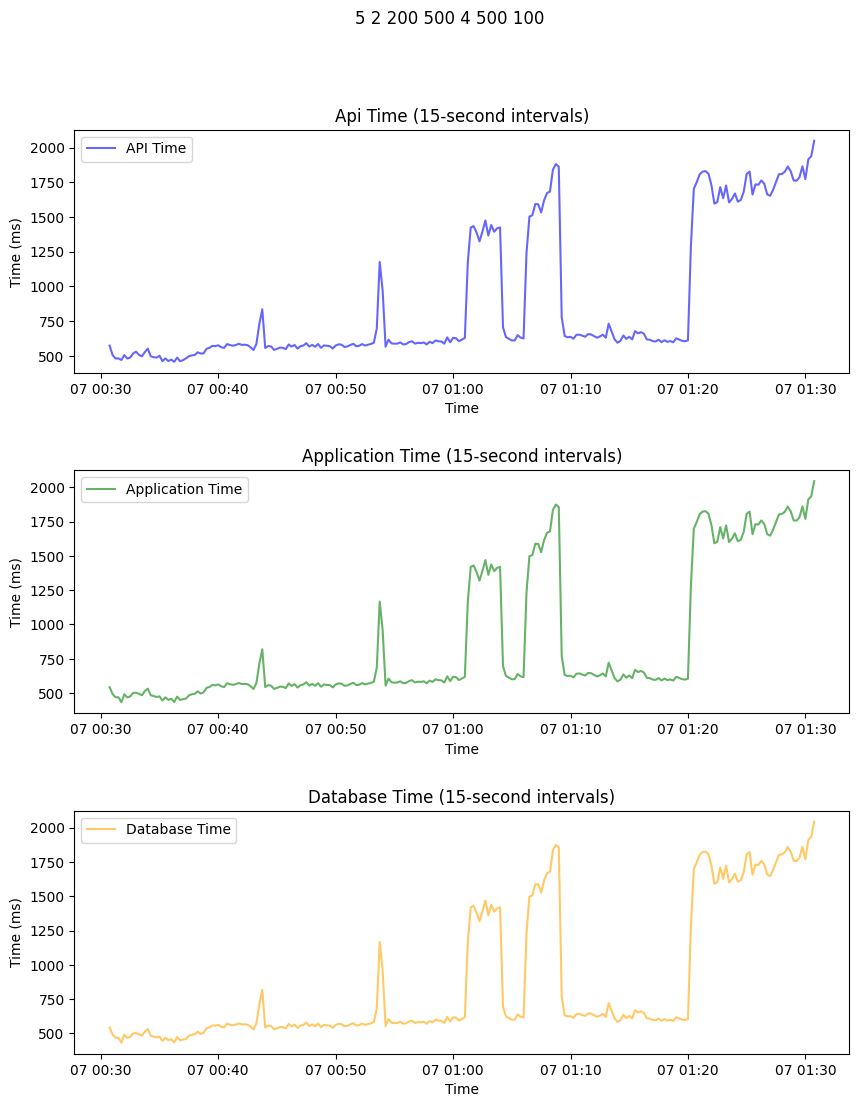

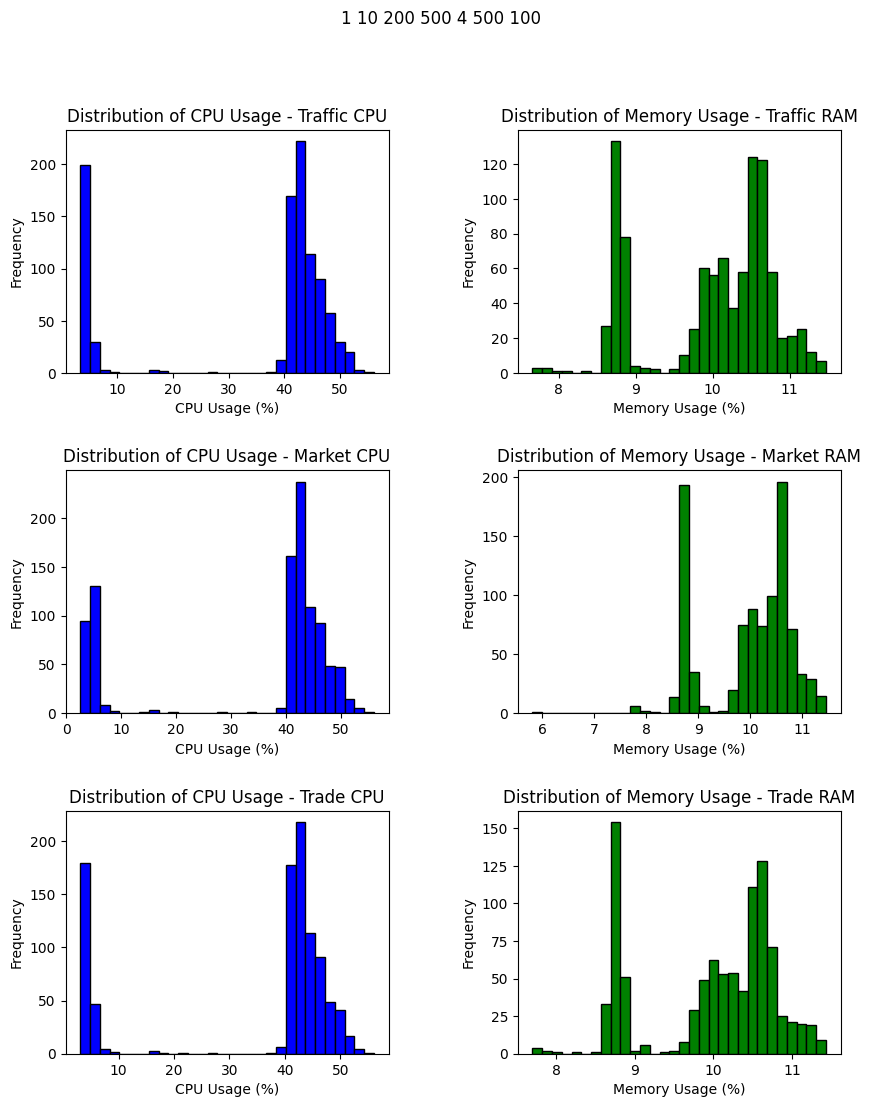

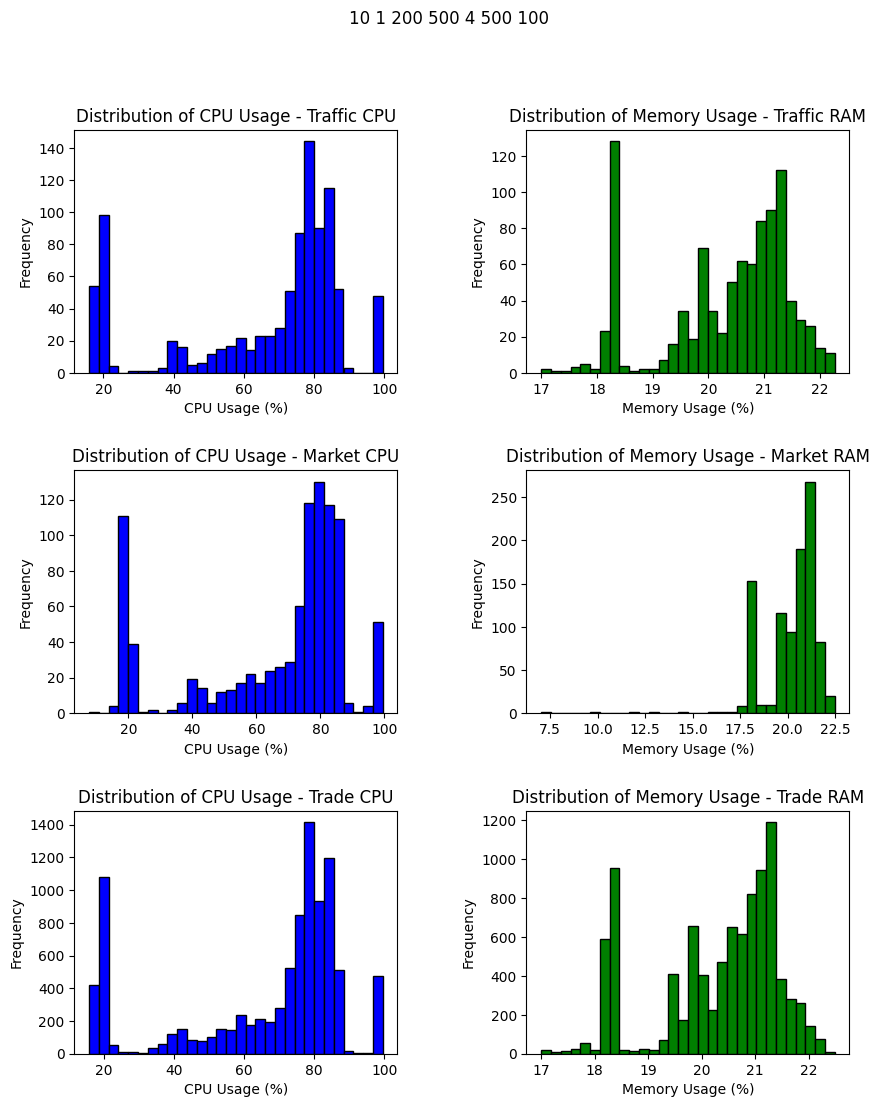

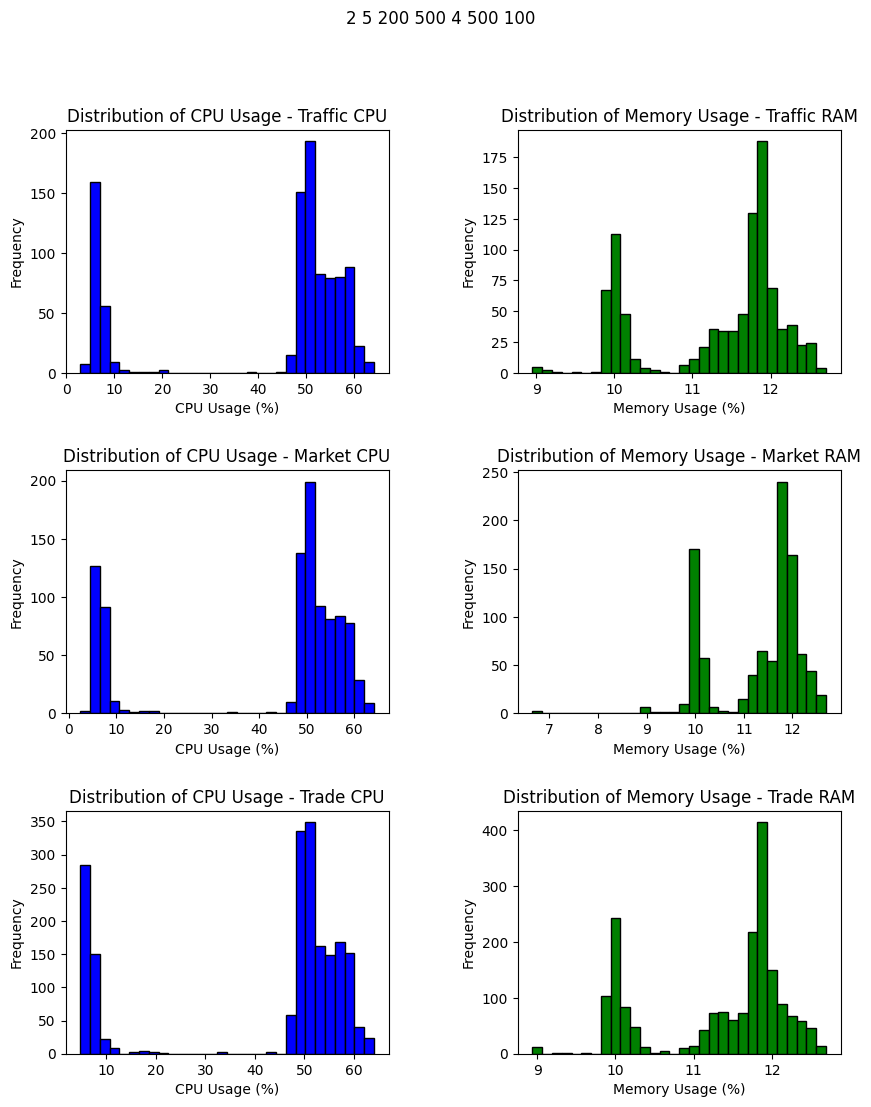

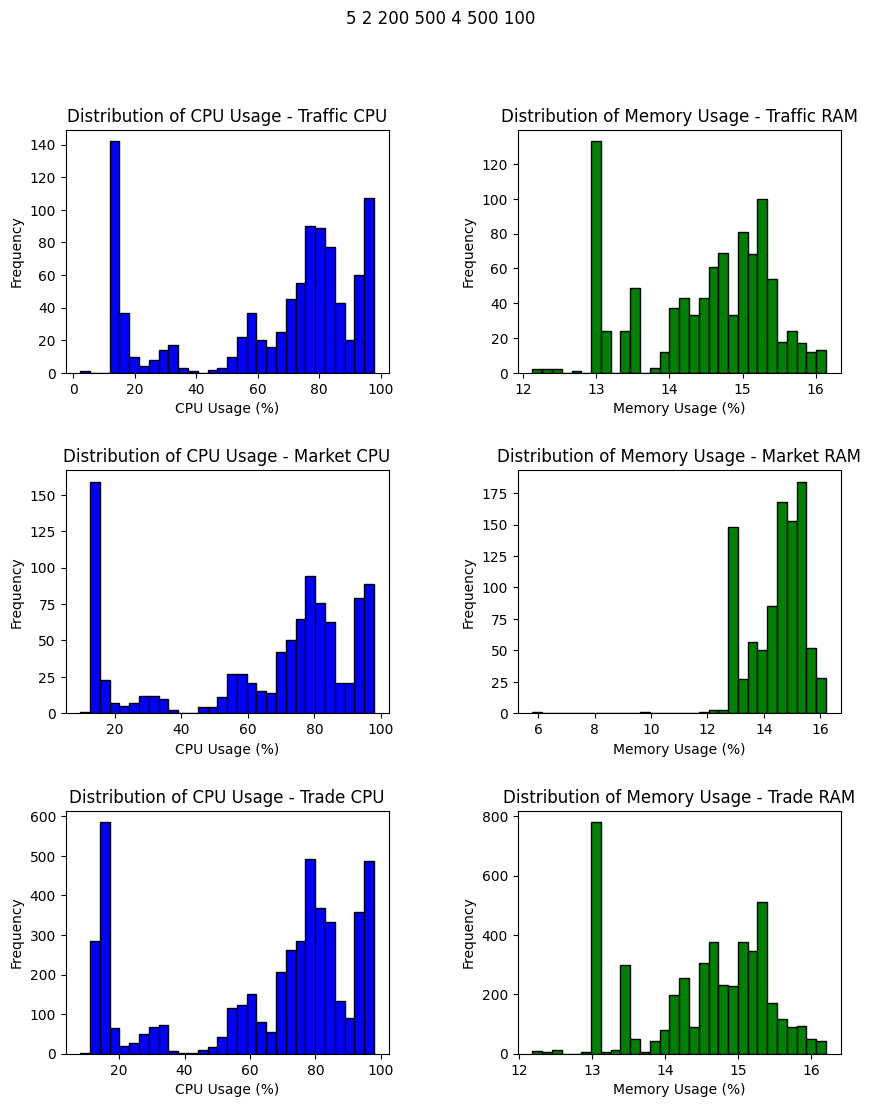

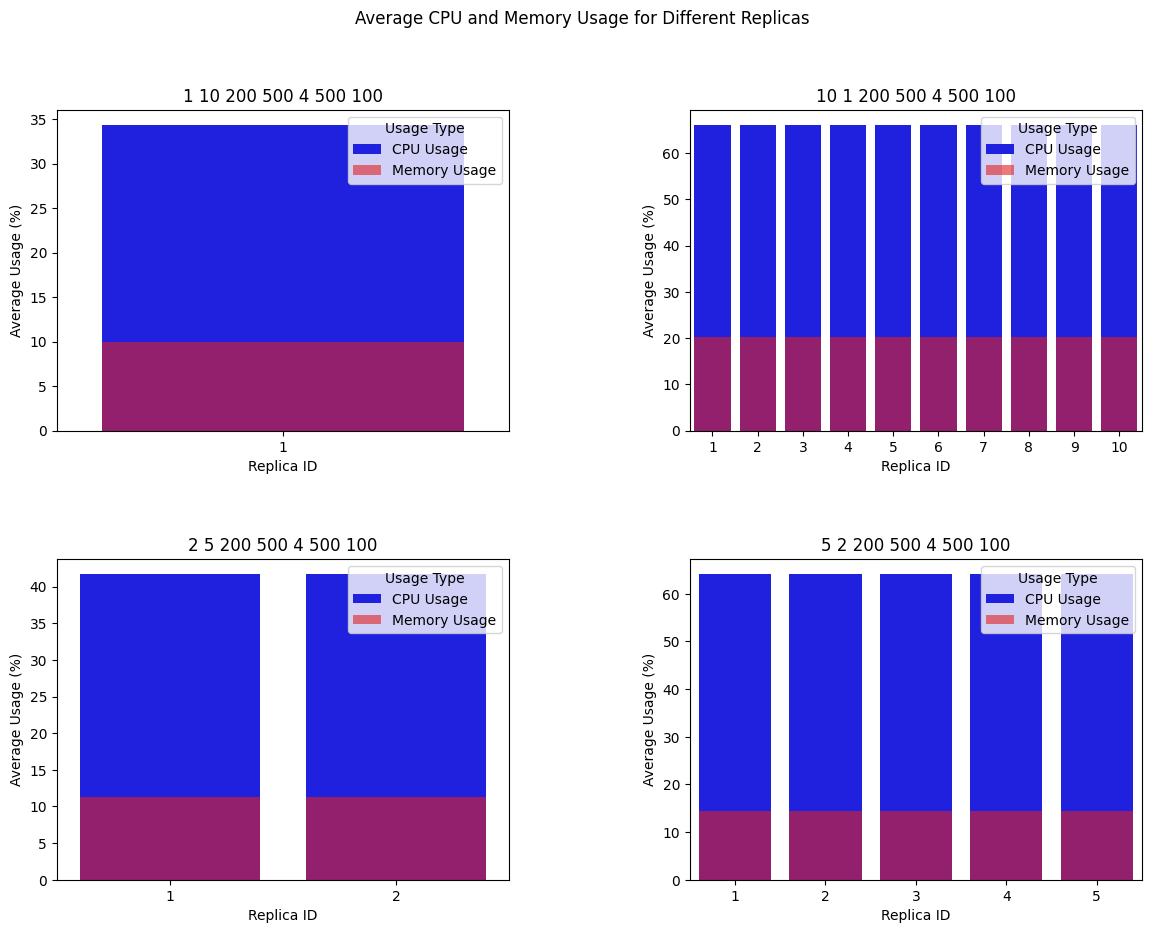

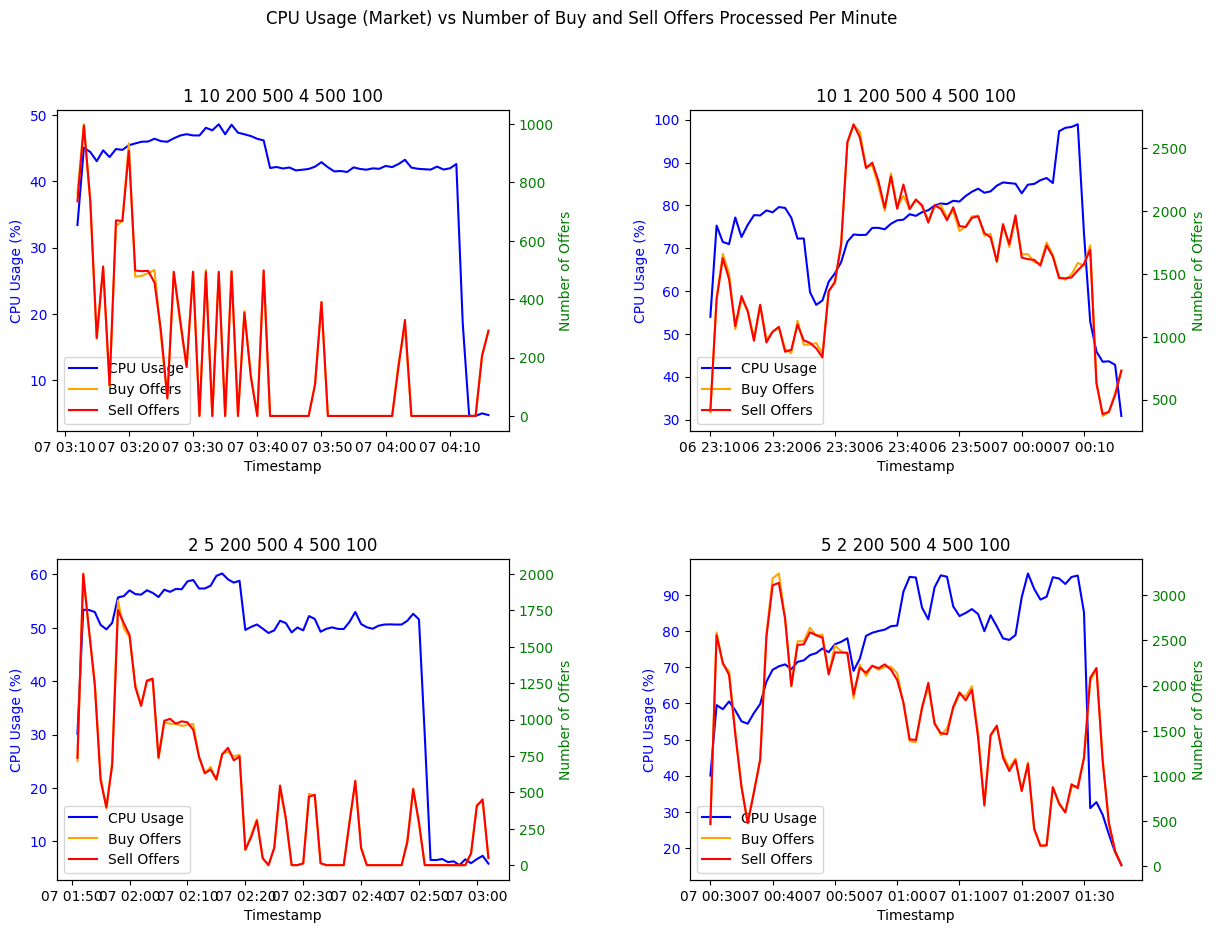

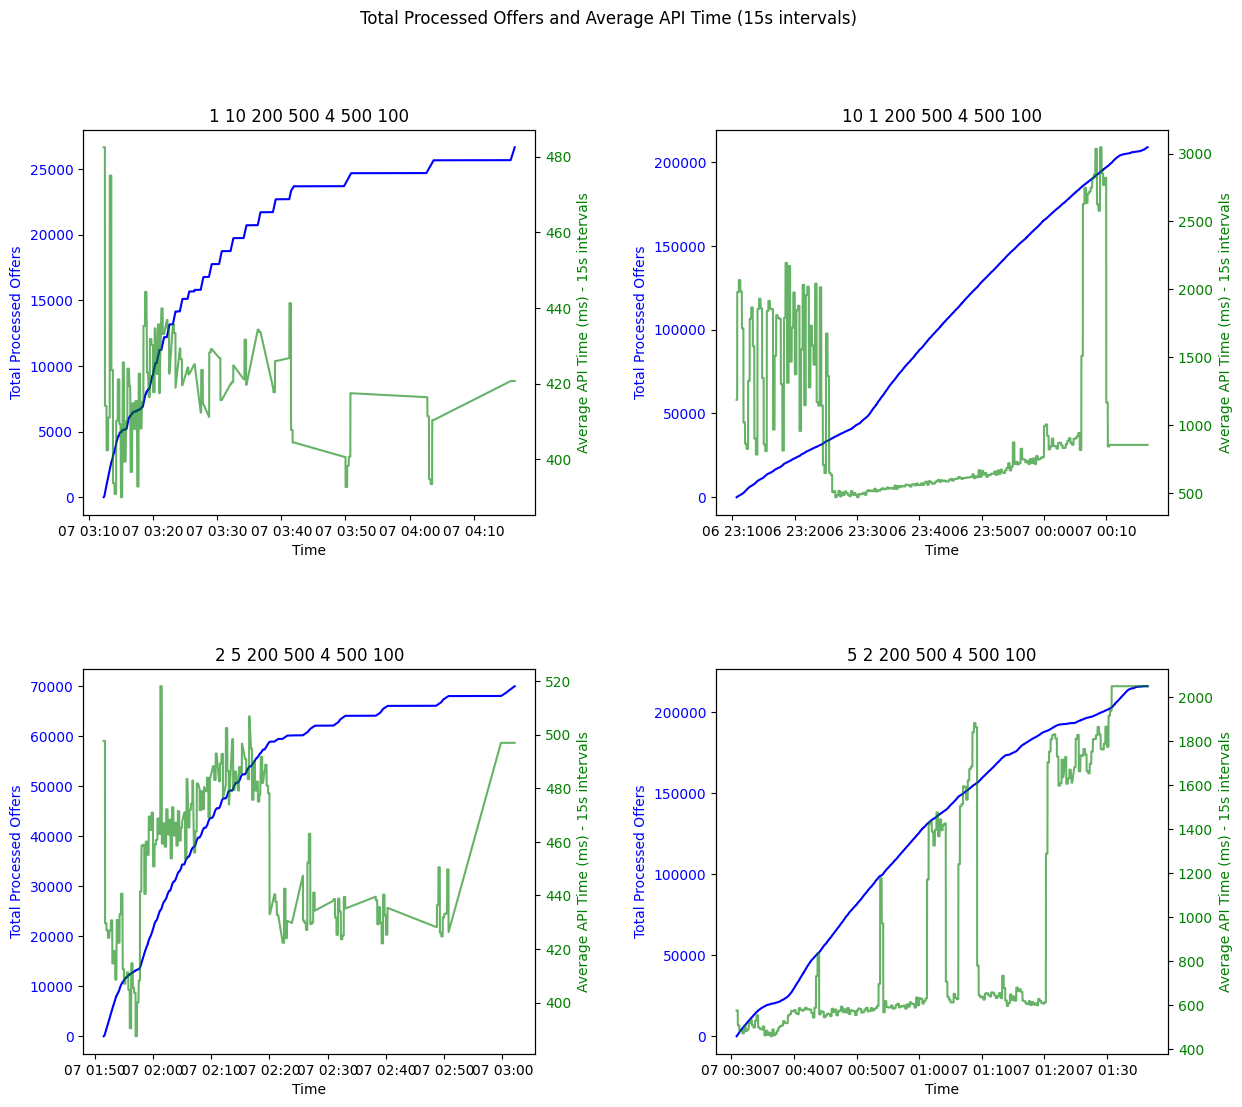

In [15]:
# Użycie funkcji do załadowania danych
base_dir = 'test1'  # ścieżka do katalogu test
all_data, test_paths = load_data_from_subdirectories(base_dir)
draw_all_subplots(all_data)

# Test 2

Loaded data from test2\4 3 200 500 16 500 100 successfully.
Loaded data from test2\4 3 200 500 2 500 100 successfully.
Loaded data from test2\4 3 200 500 4 500 100 successfully.
Loaded data from test2\4 3 200 500 8 500 100 successfully.


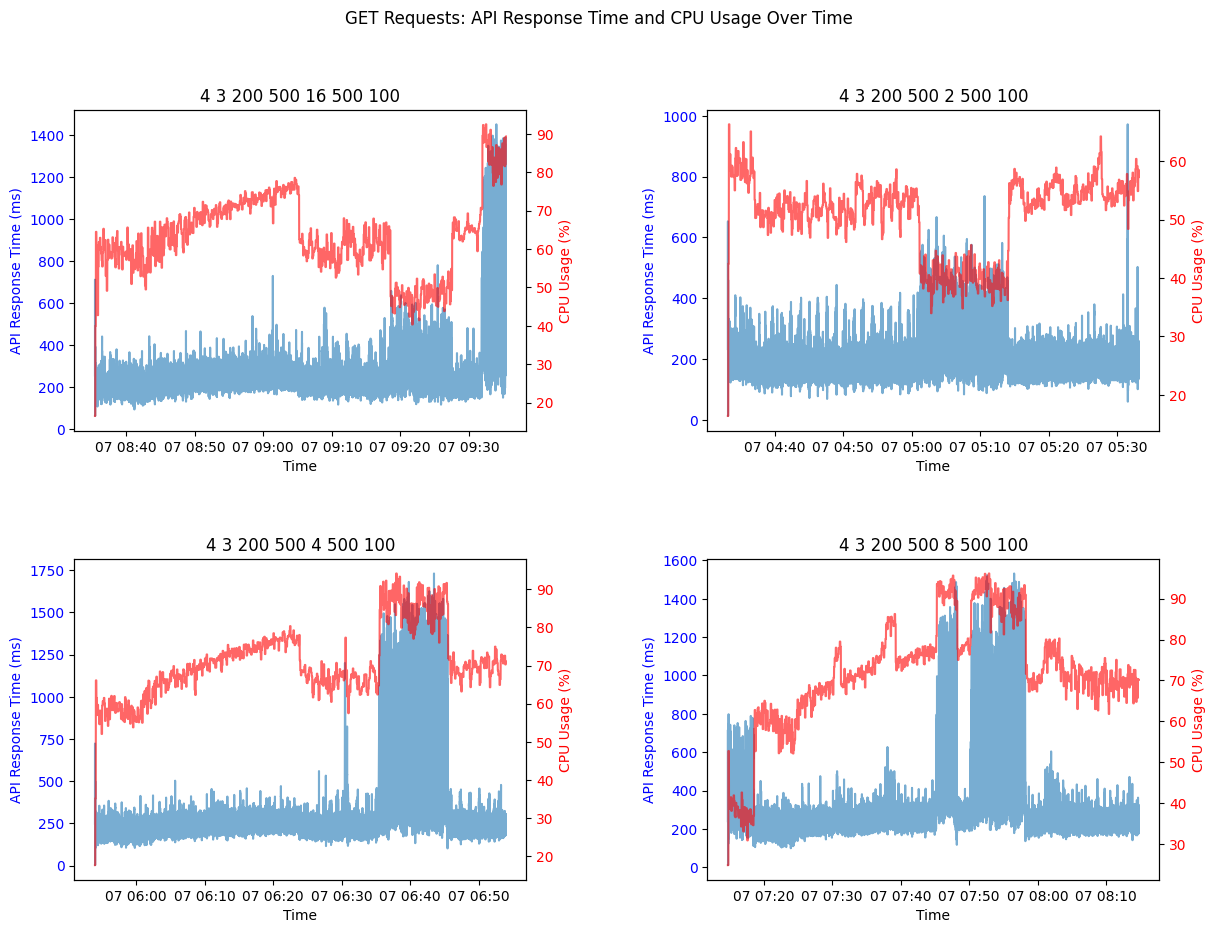

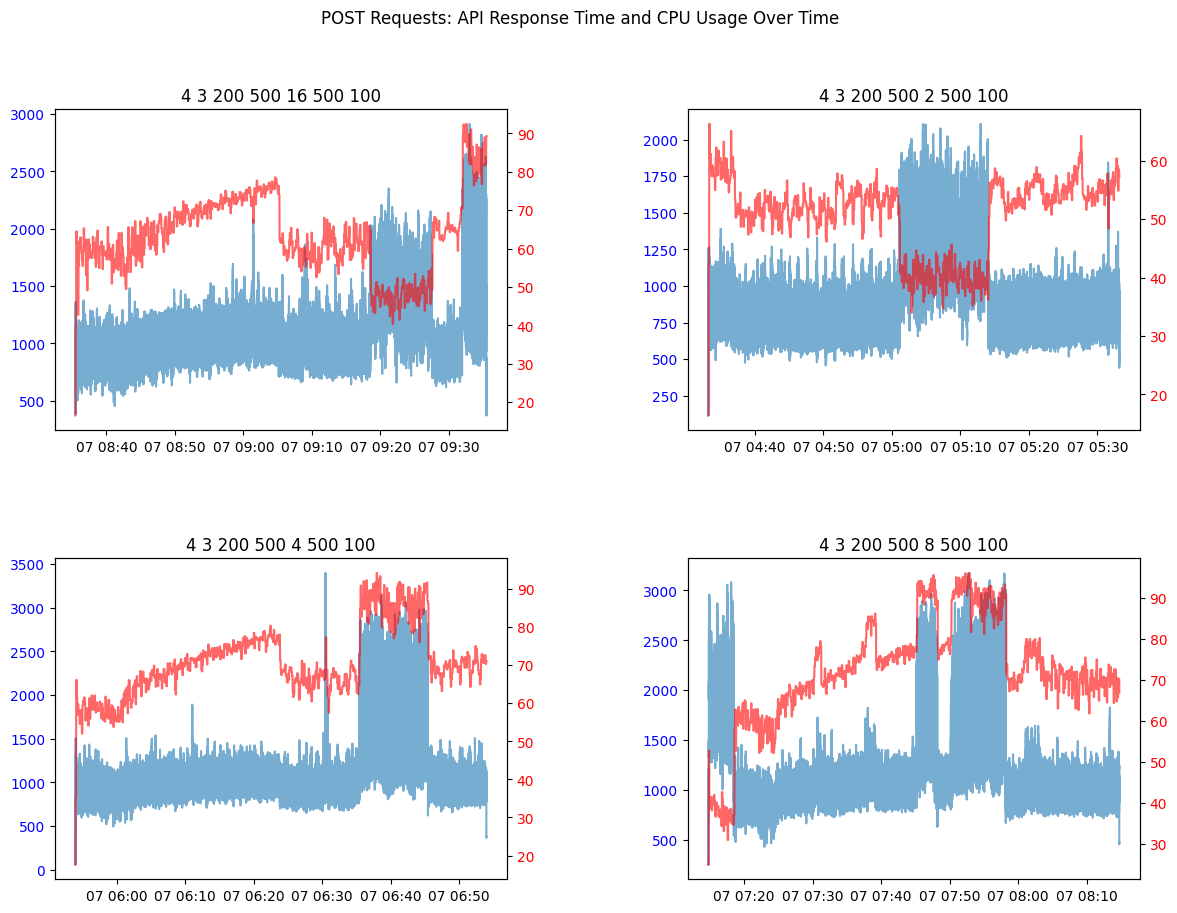

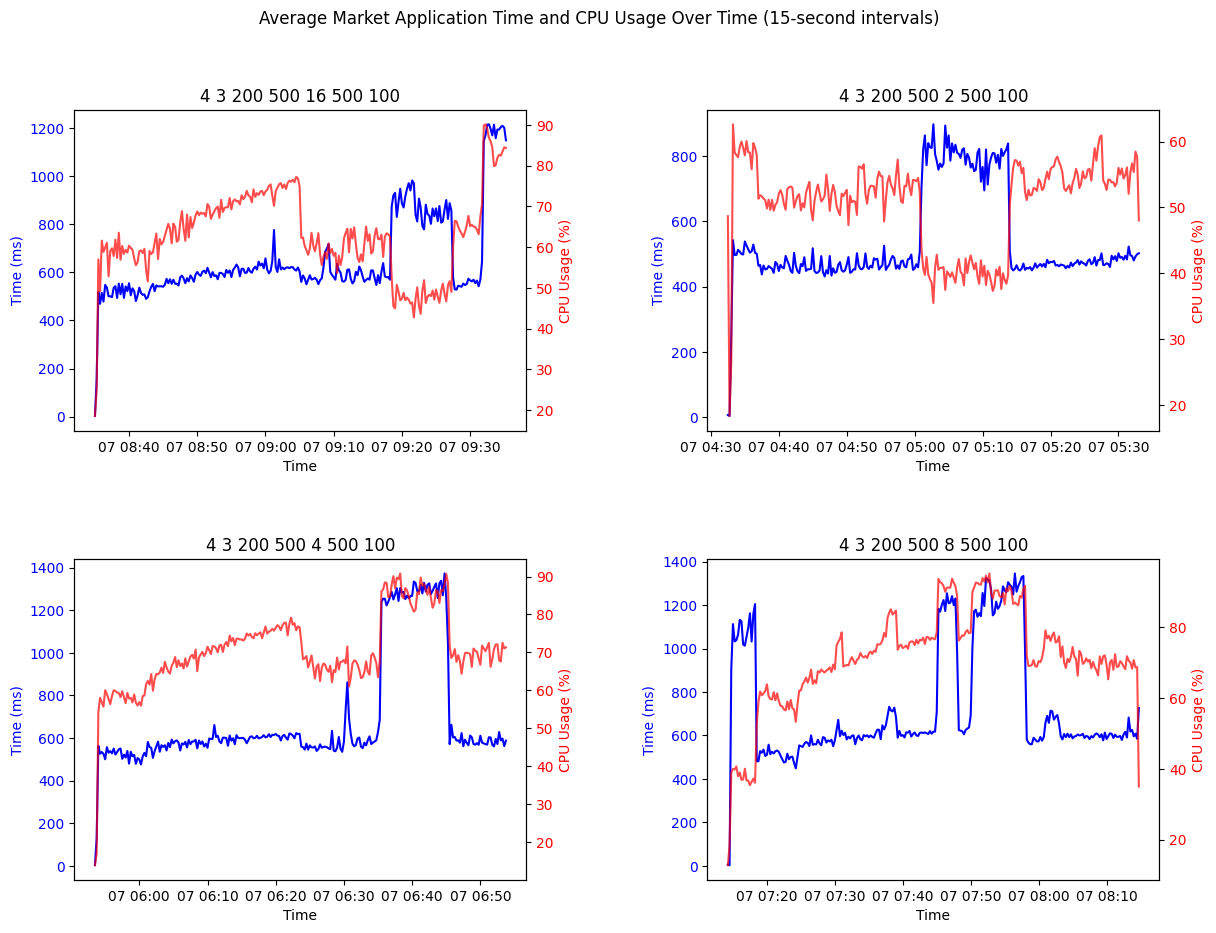

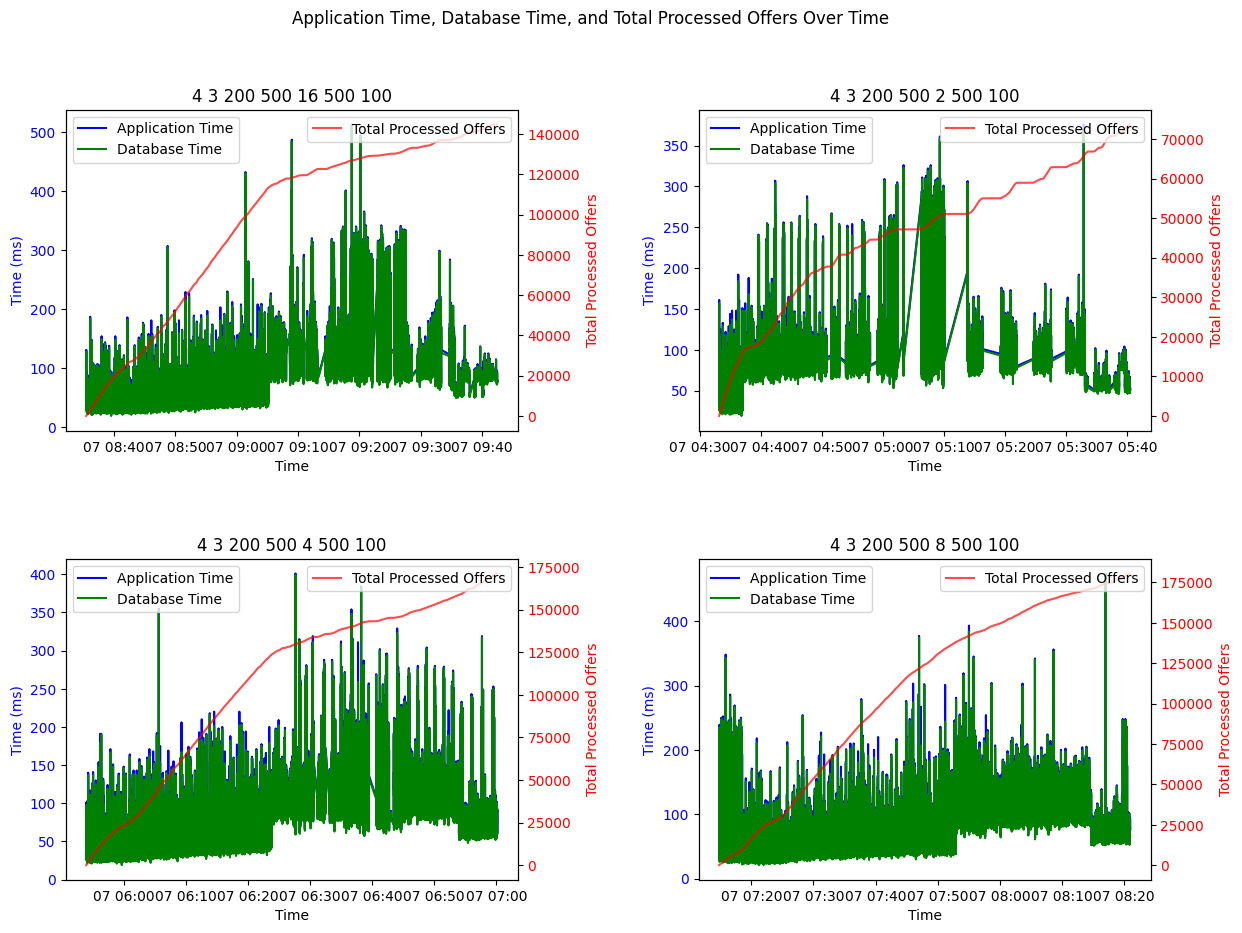

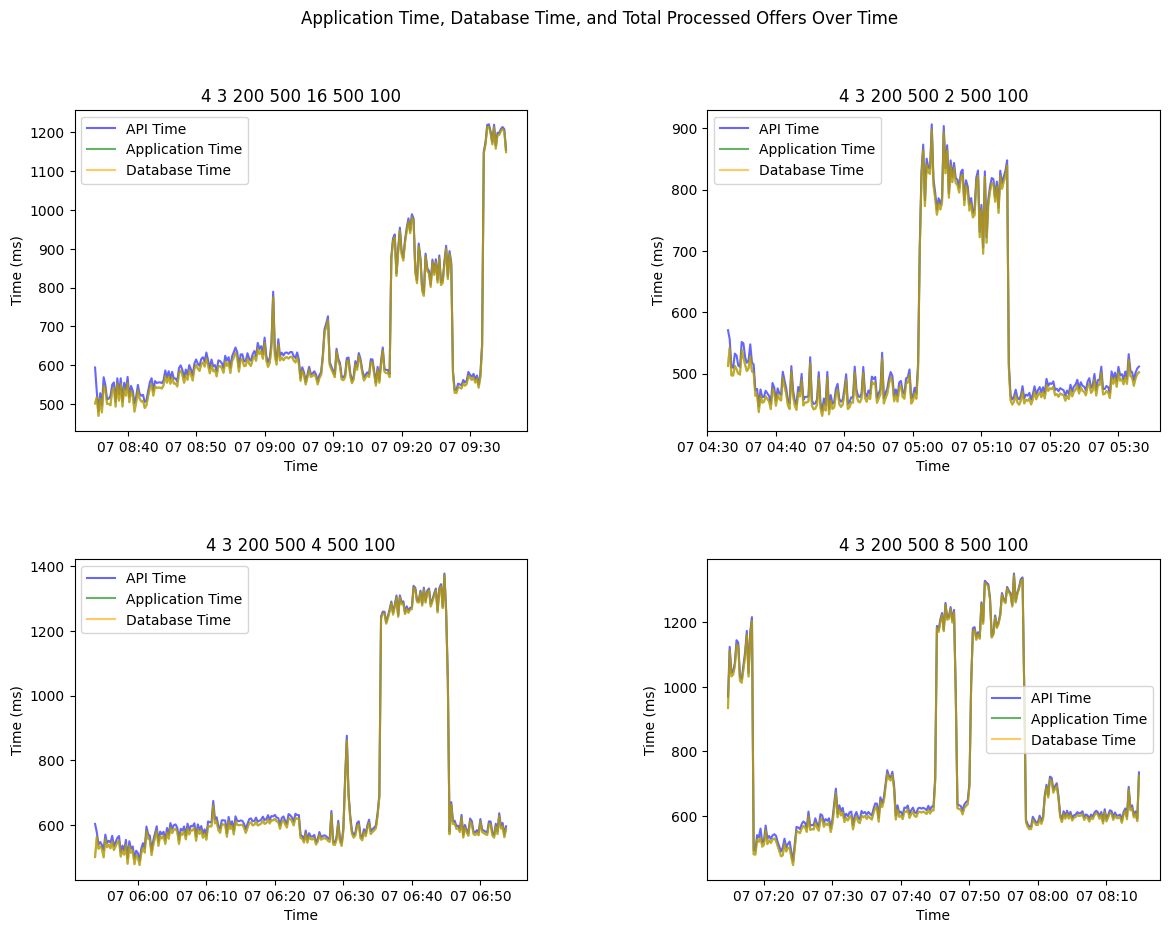

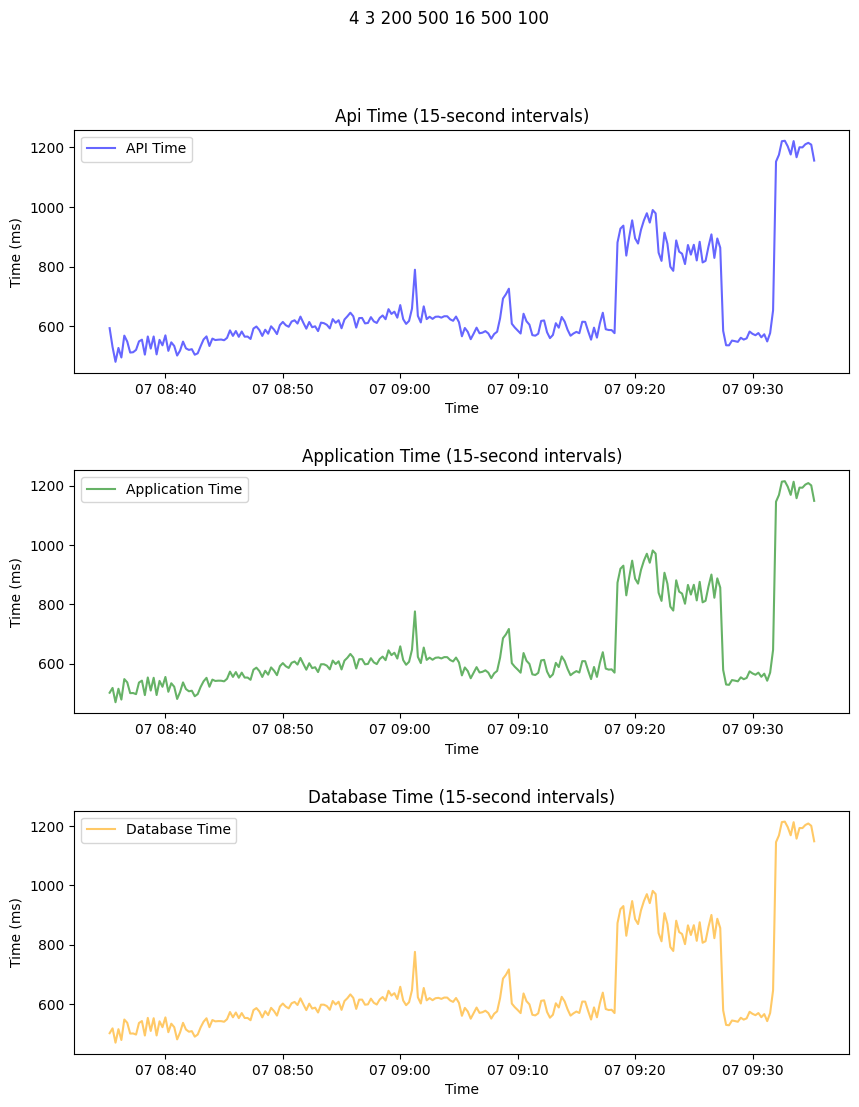

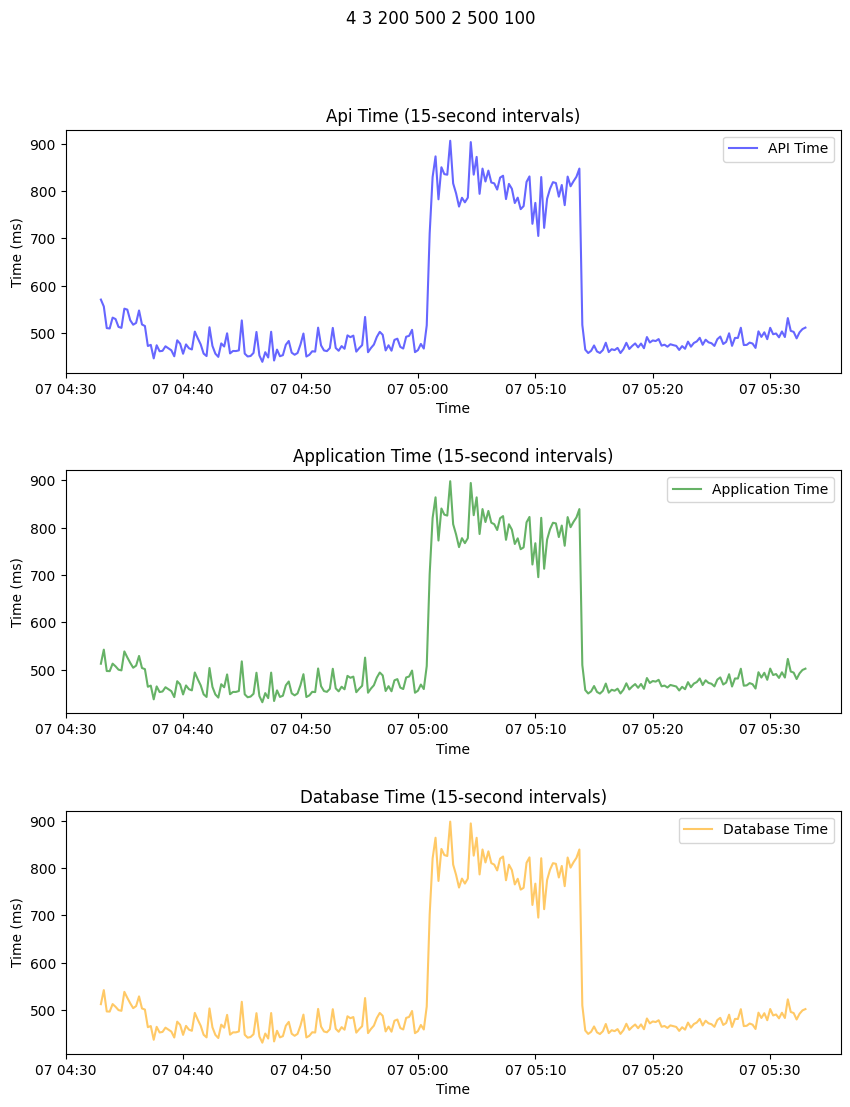

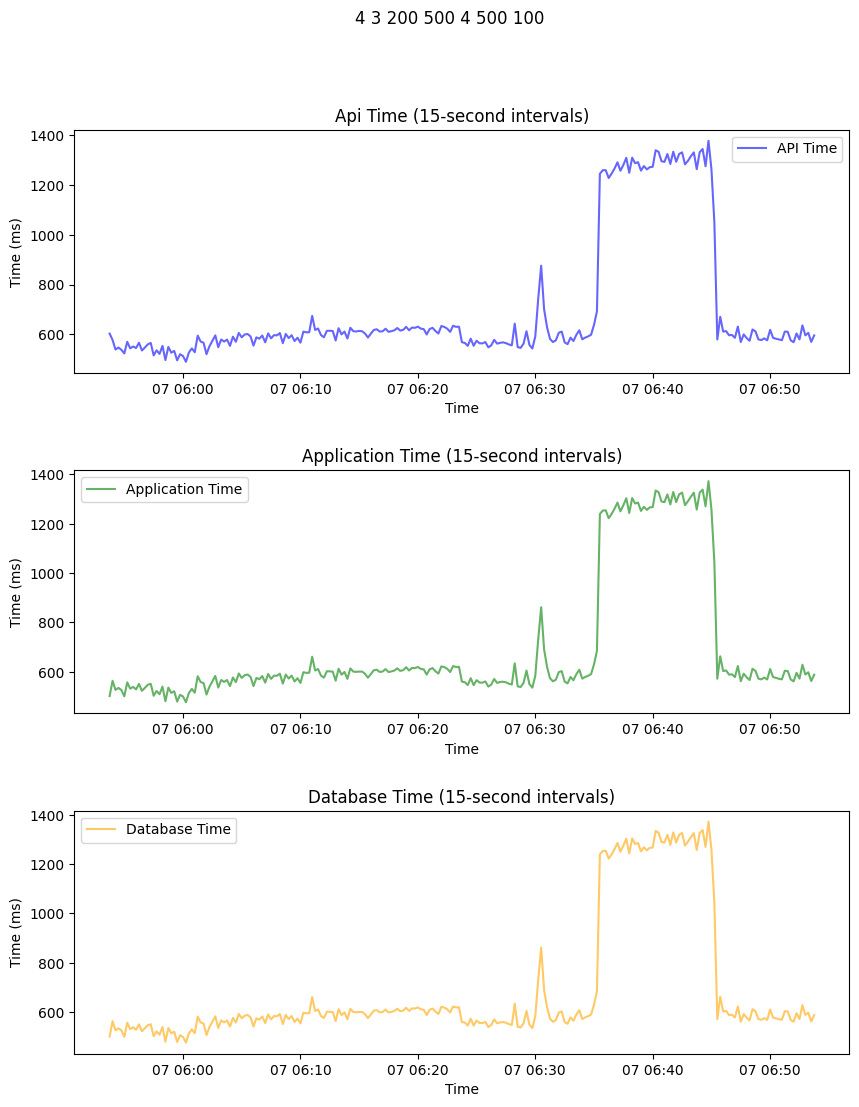

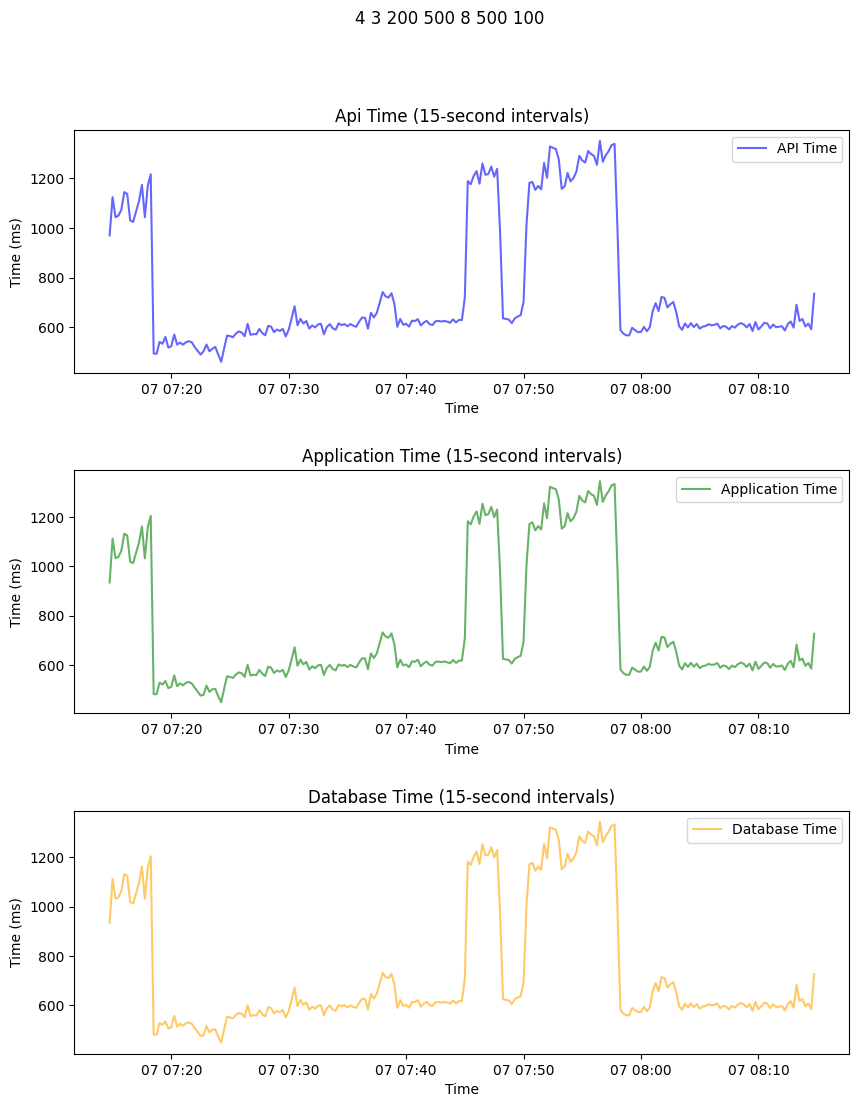

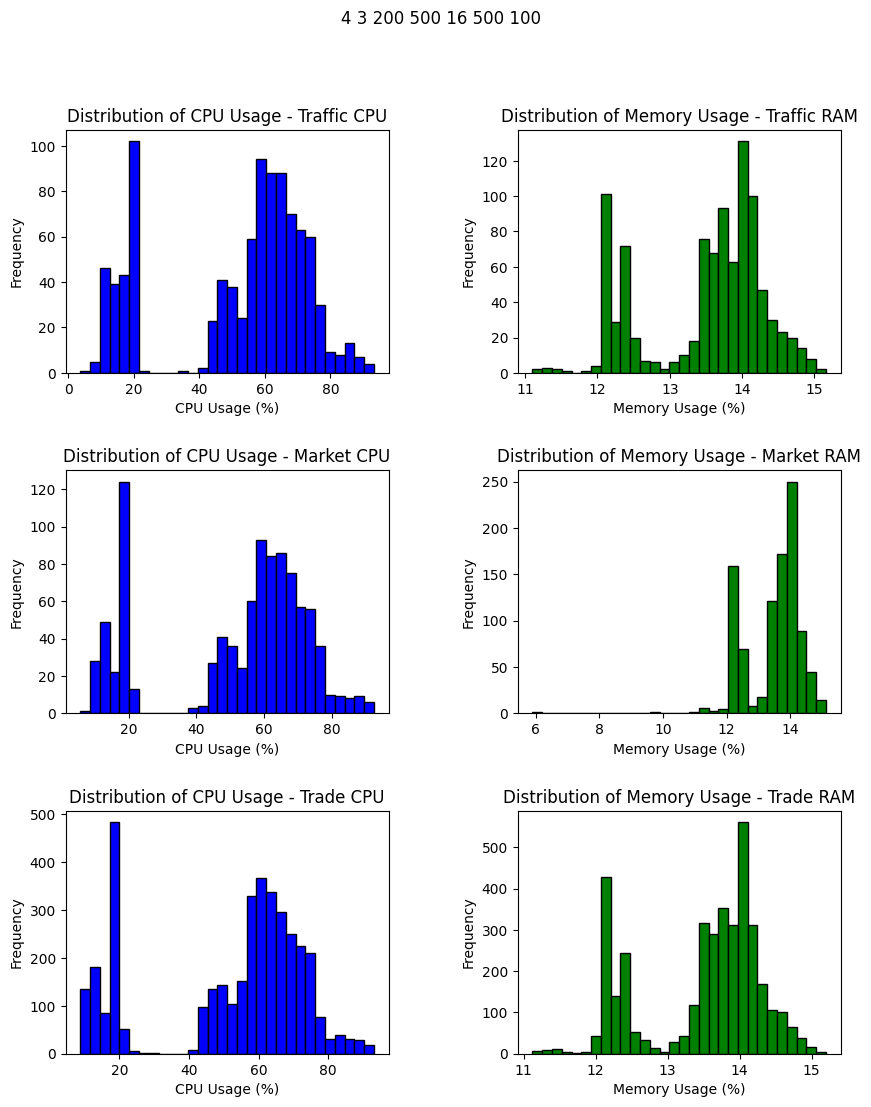

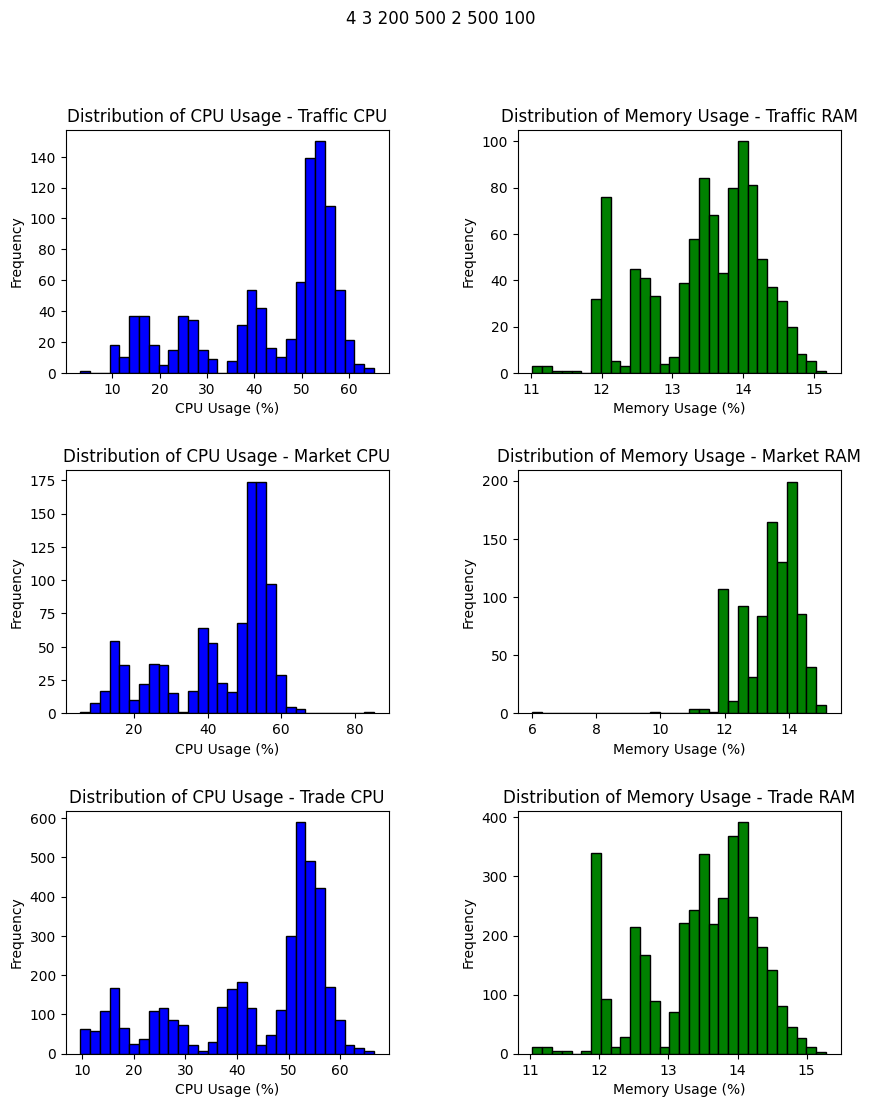

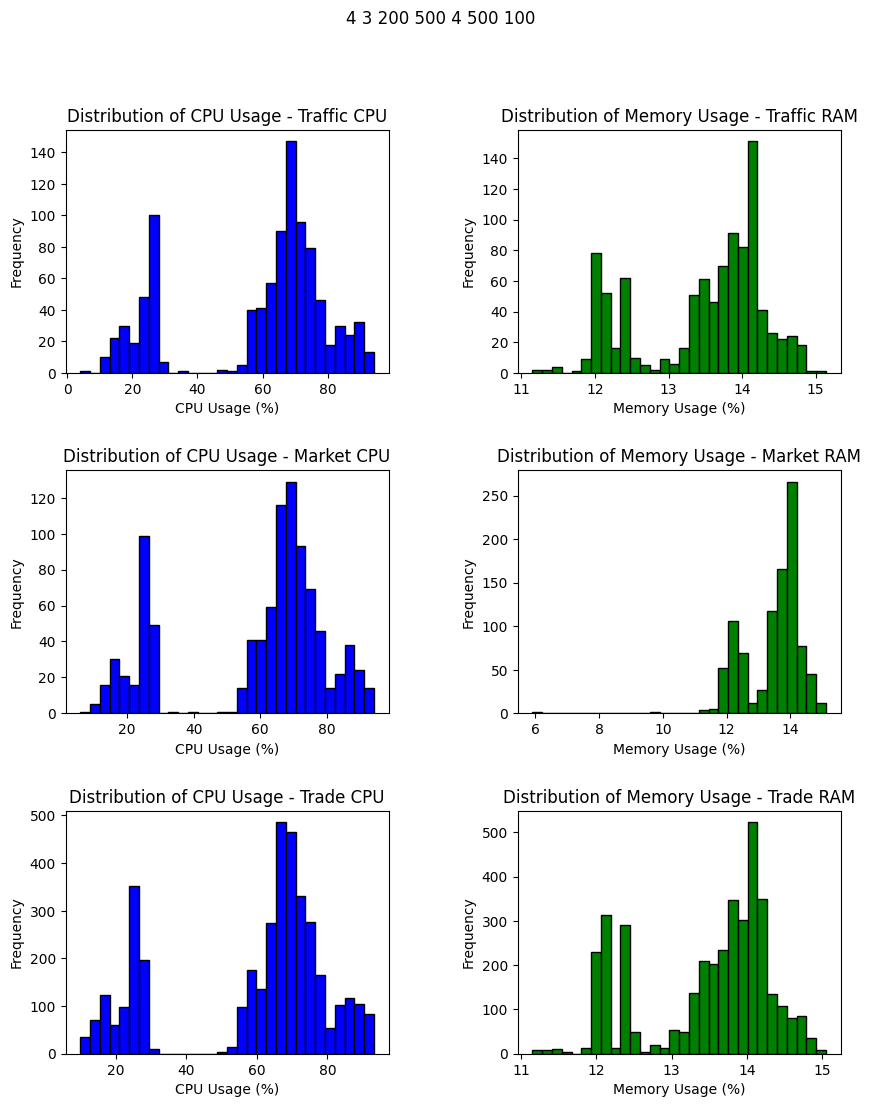

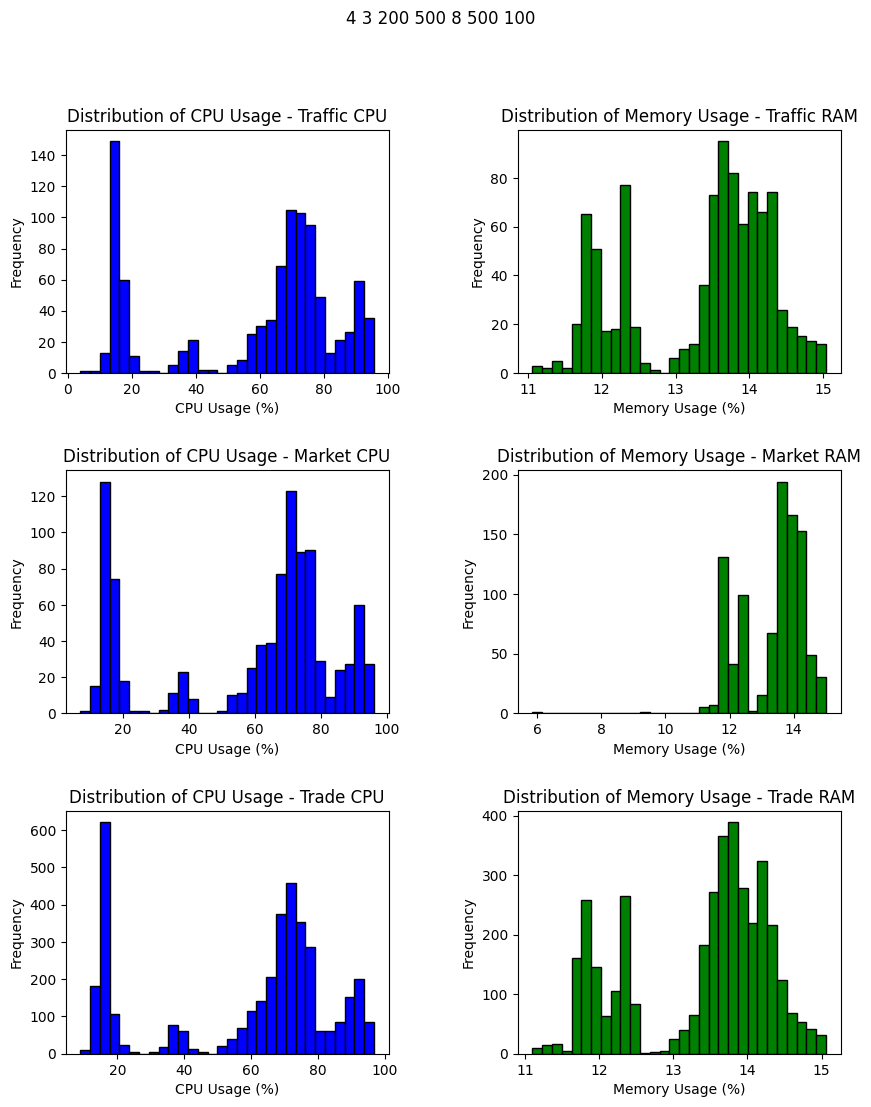

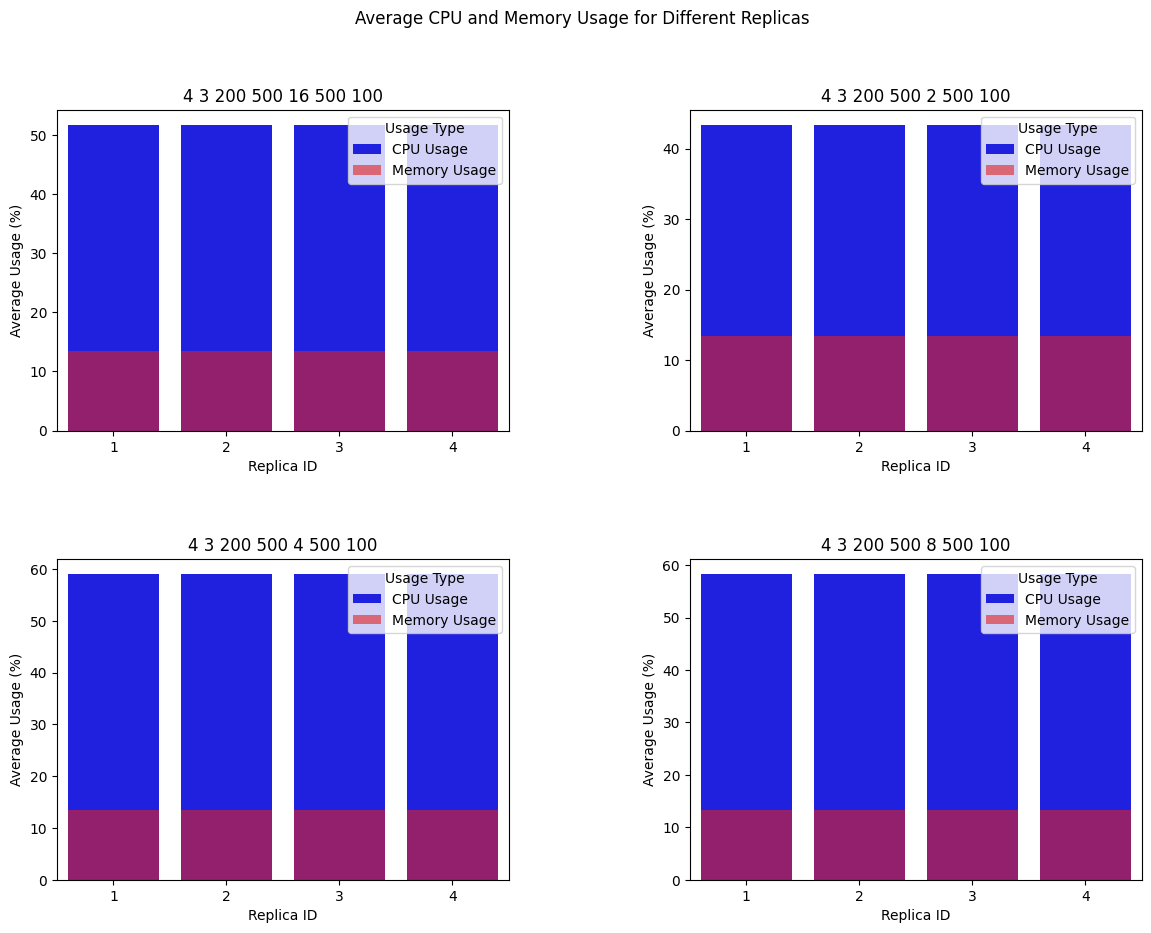

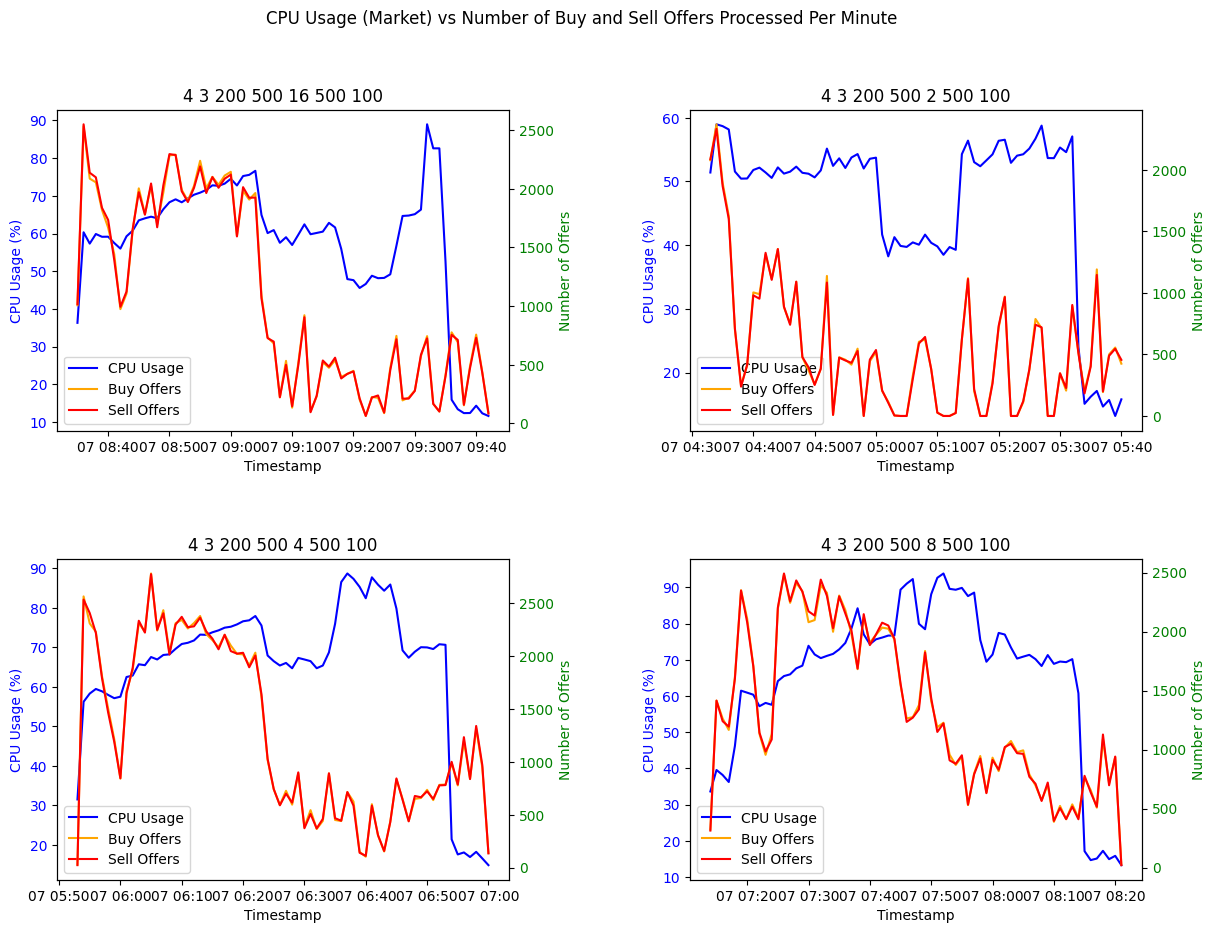

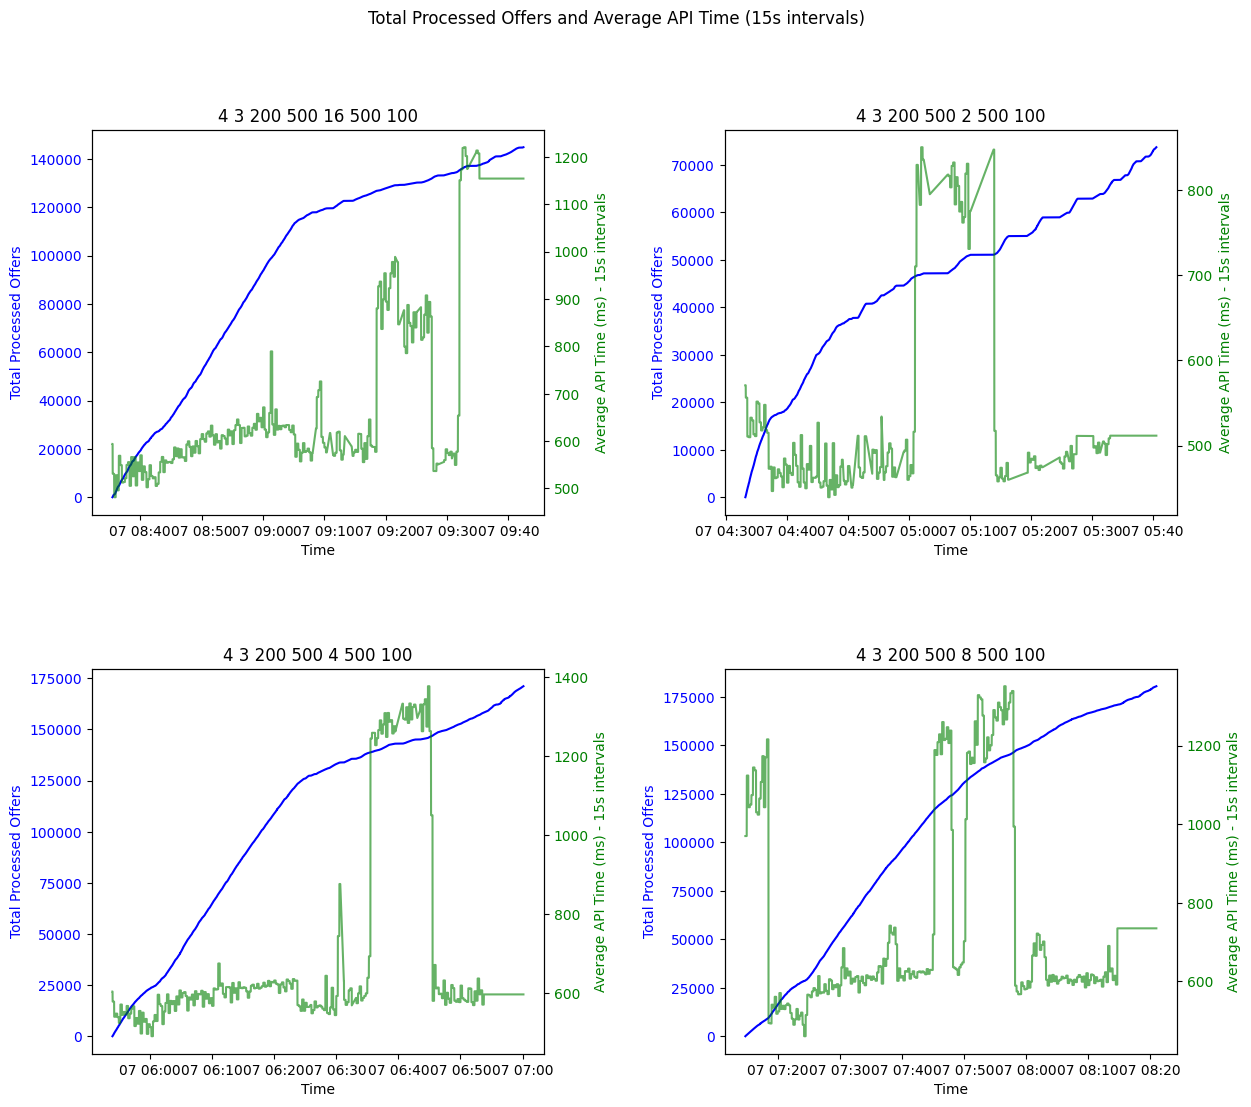

In [16]:
# Użycie funkcji do załadowania danych
base_dir = 'test2'  # ścieżka do katalogu test
all_data, test_paths = load_data_from_subdirectories(base_dir)
draw_all_subplots(all_data)

# Test 3

Loaded data from test3\4 3 200 1000 4 500 100 successfully.
Loaded data from test3\4 3 200 250 4 500 100 successfully.
Loaded data from test3\4 3 200 500 4 500 100 successfully.
Loaded data from test3\4 3 200 750 4 500 100 successfully.


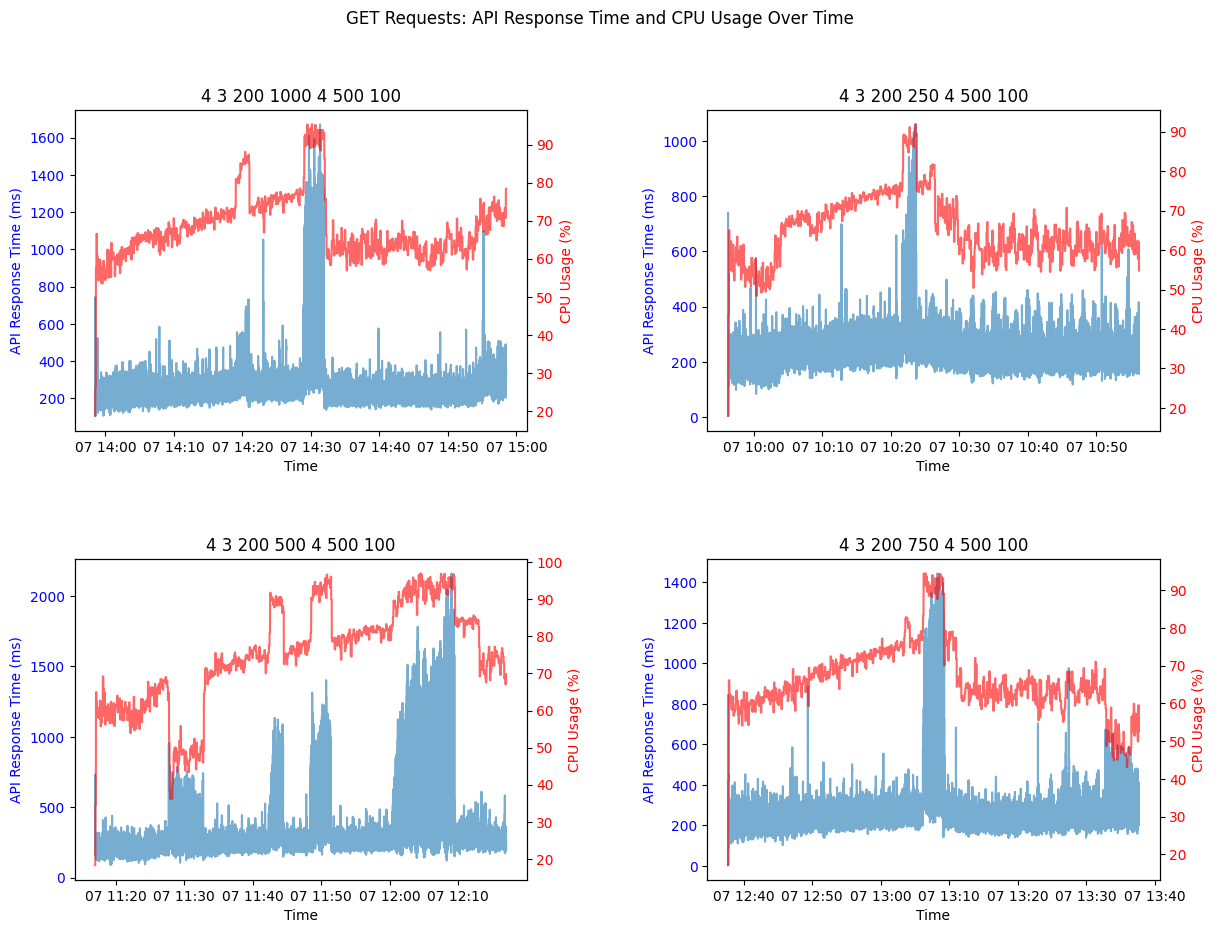

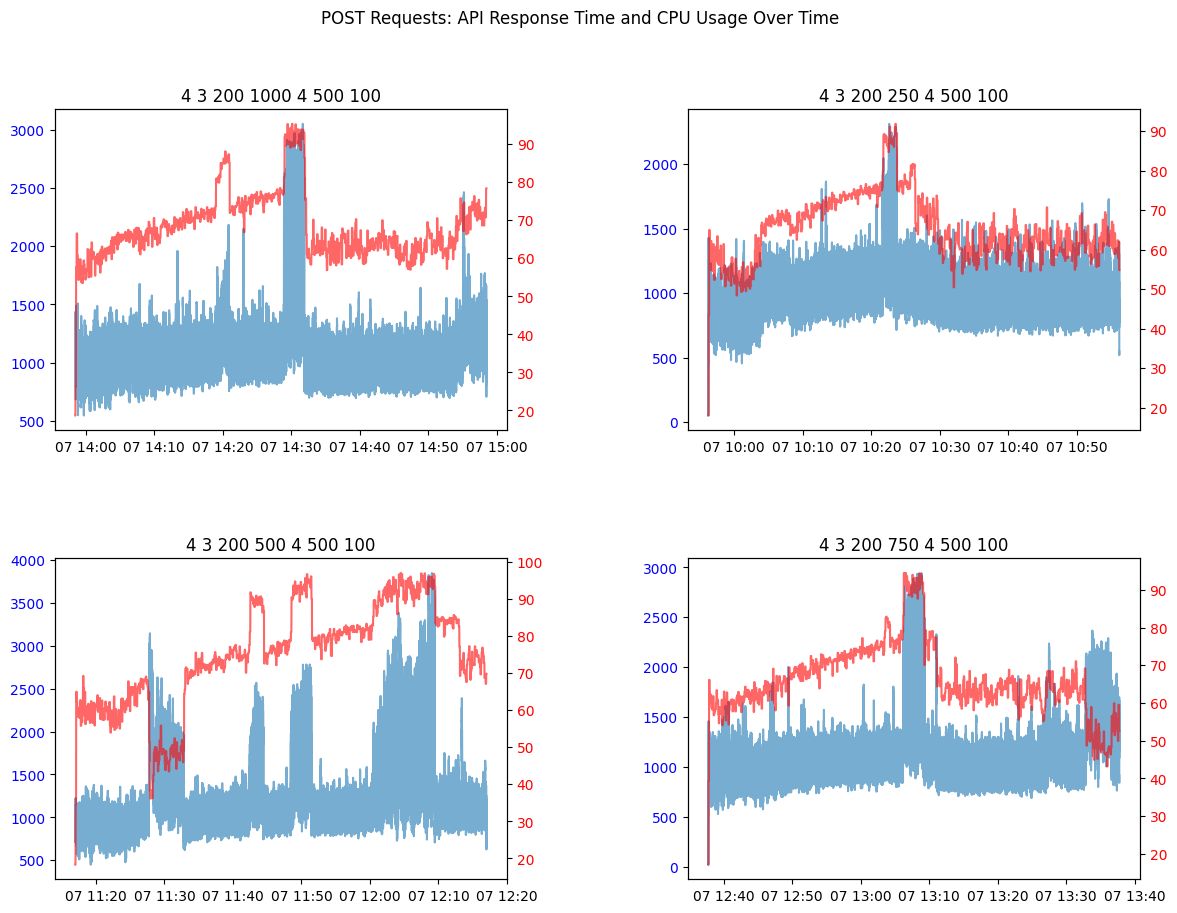

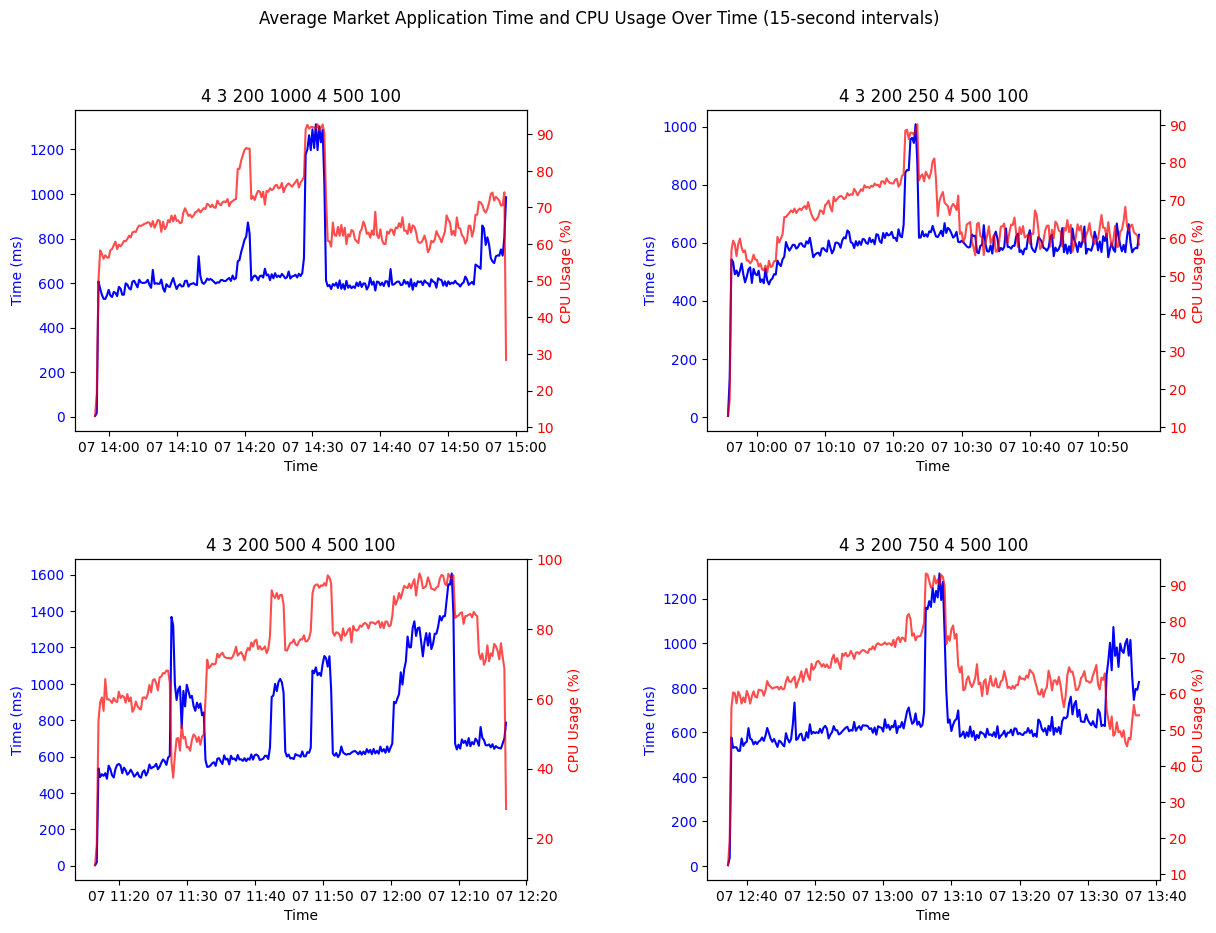

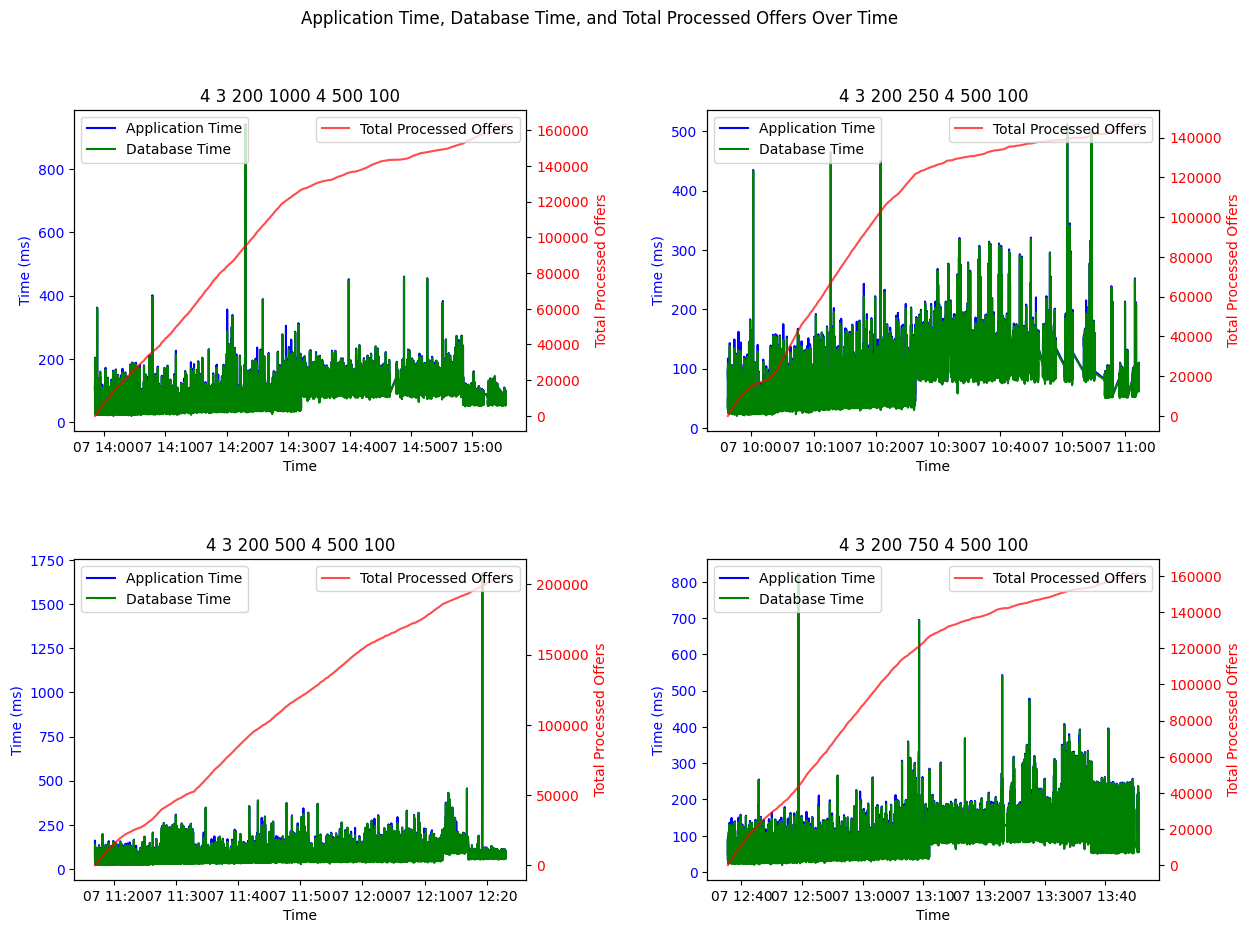

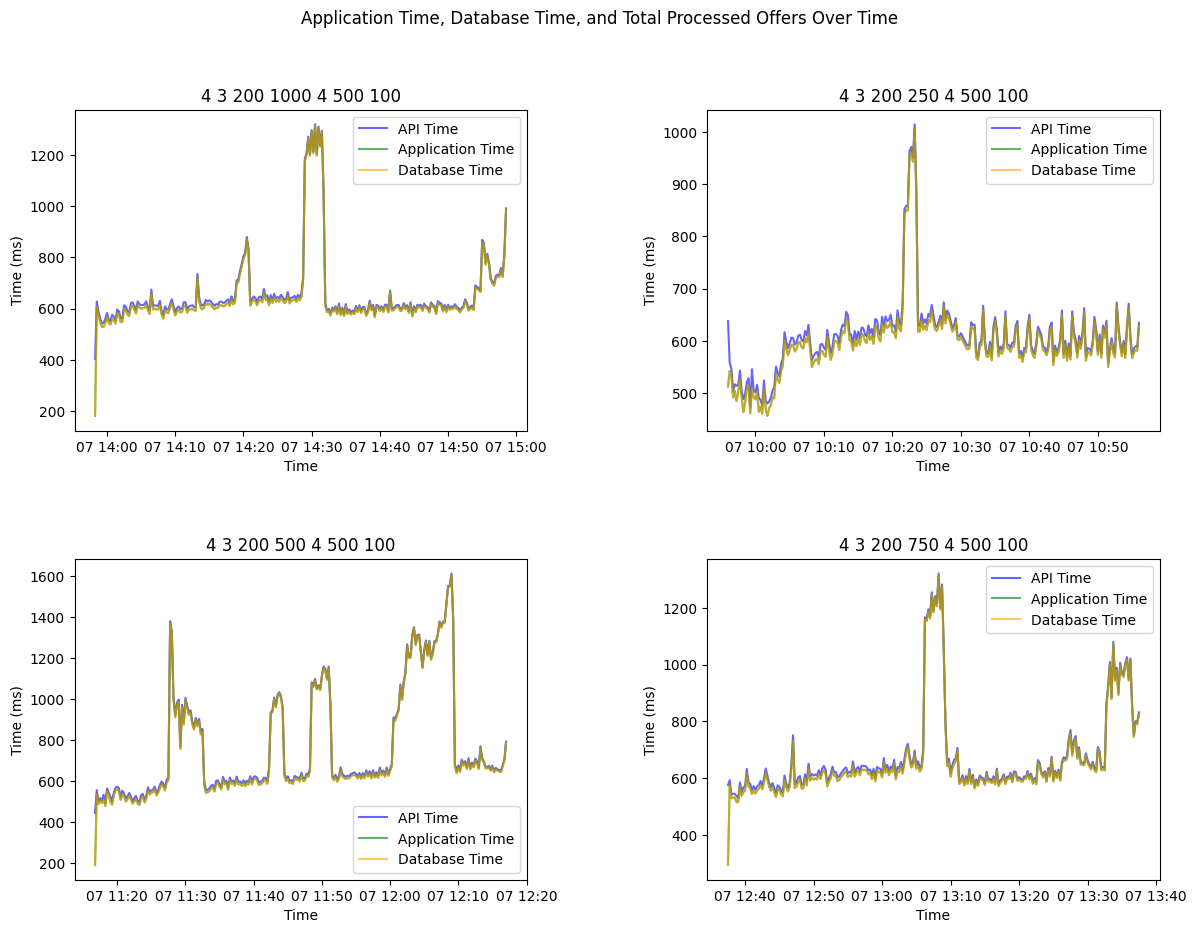

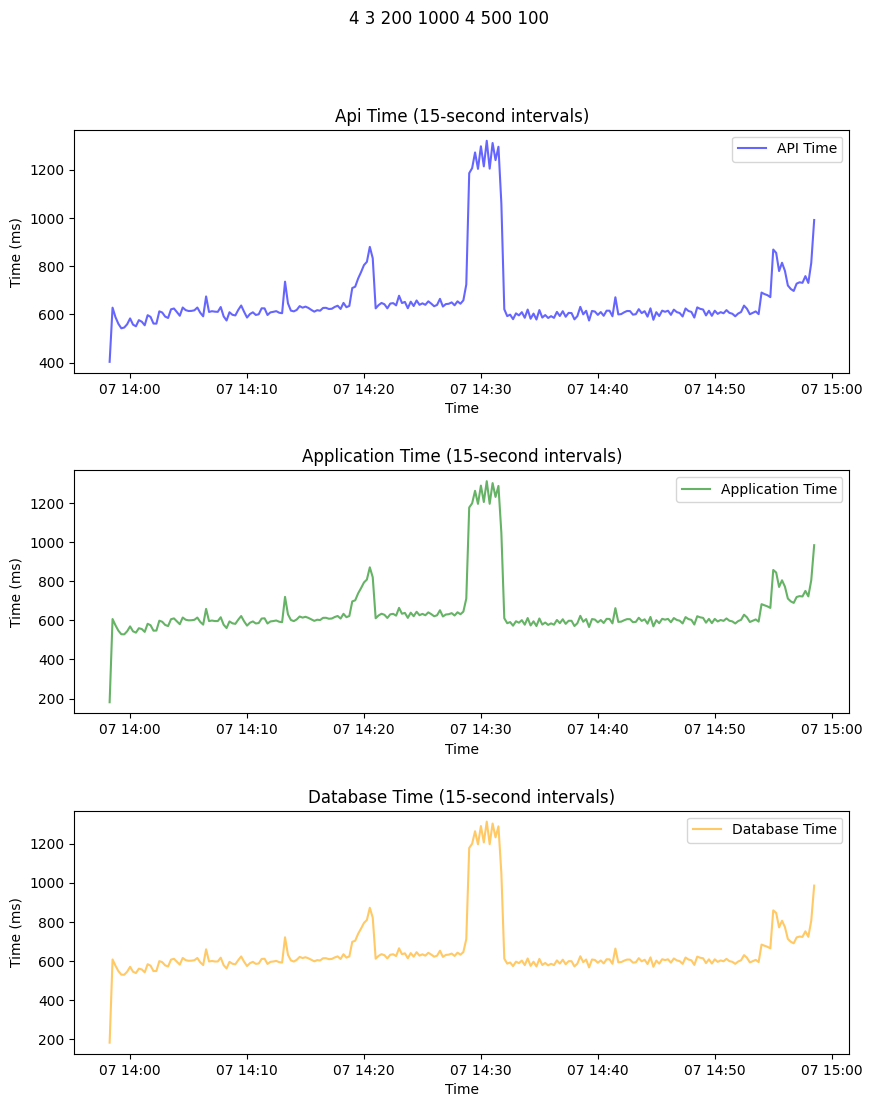

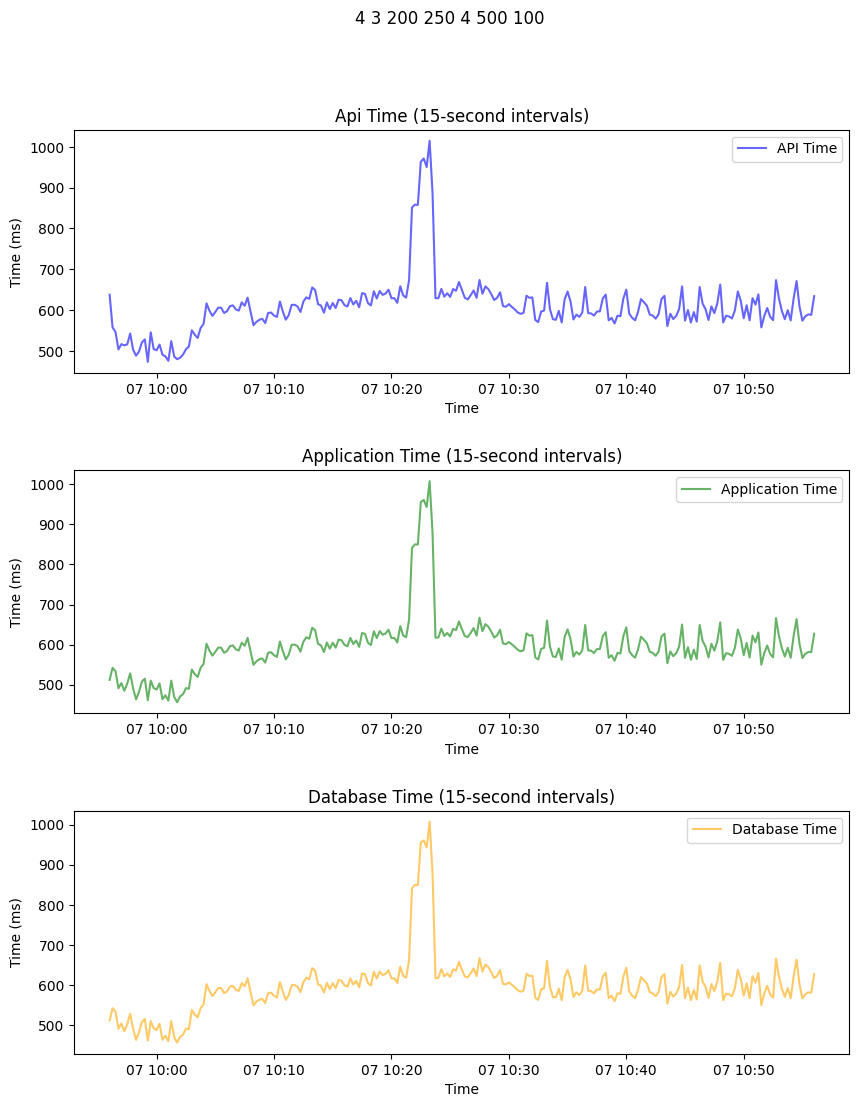

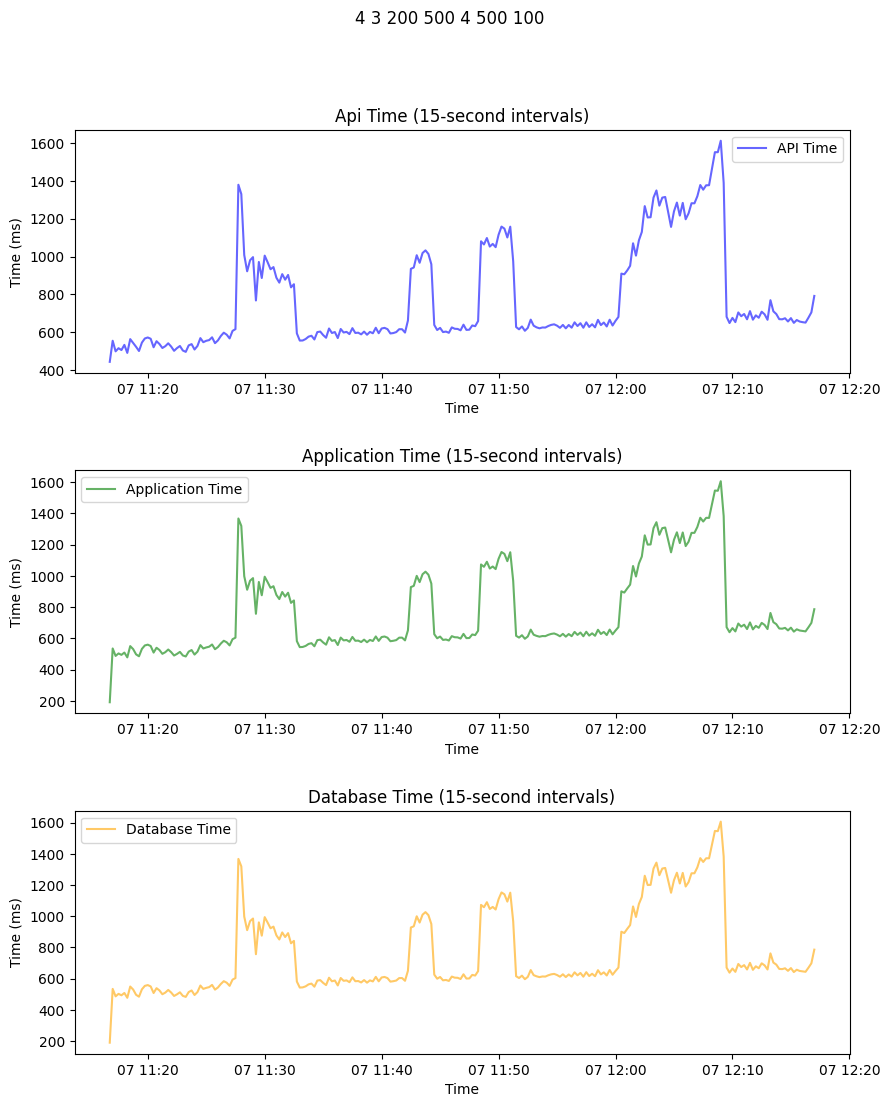

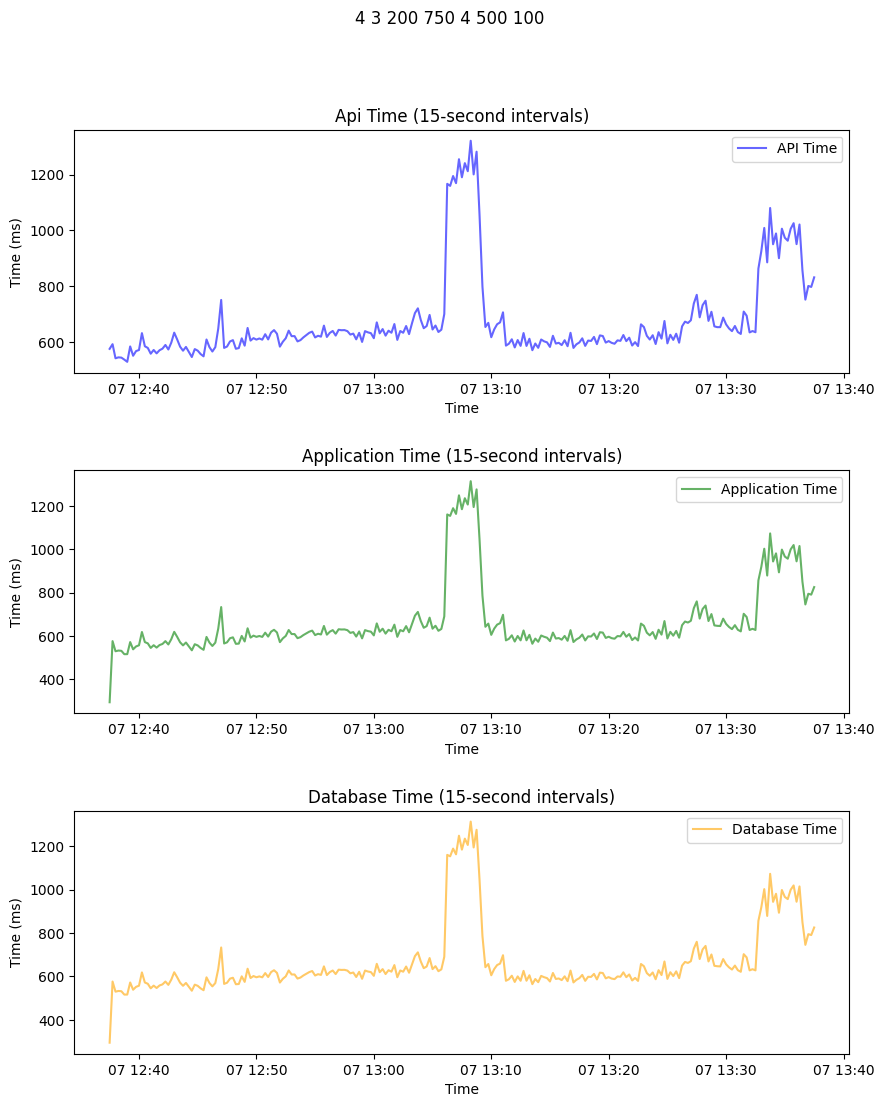

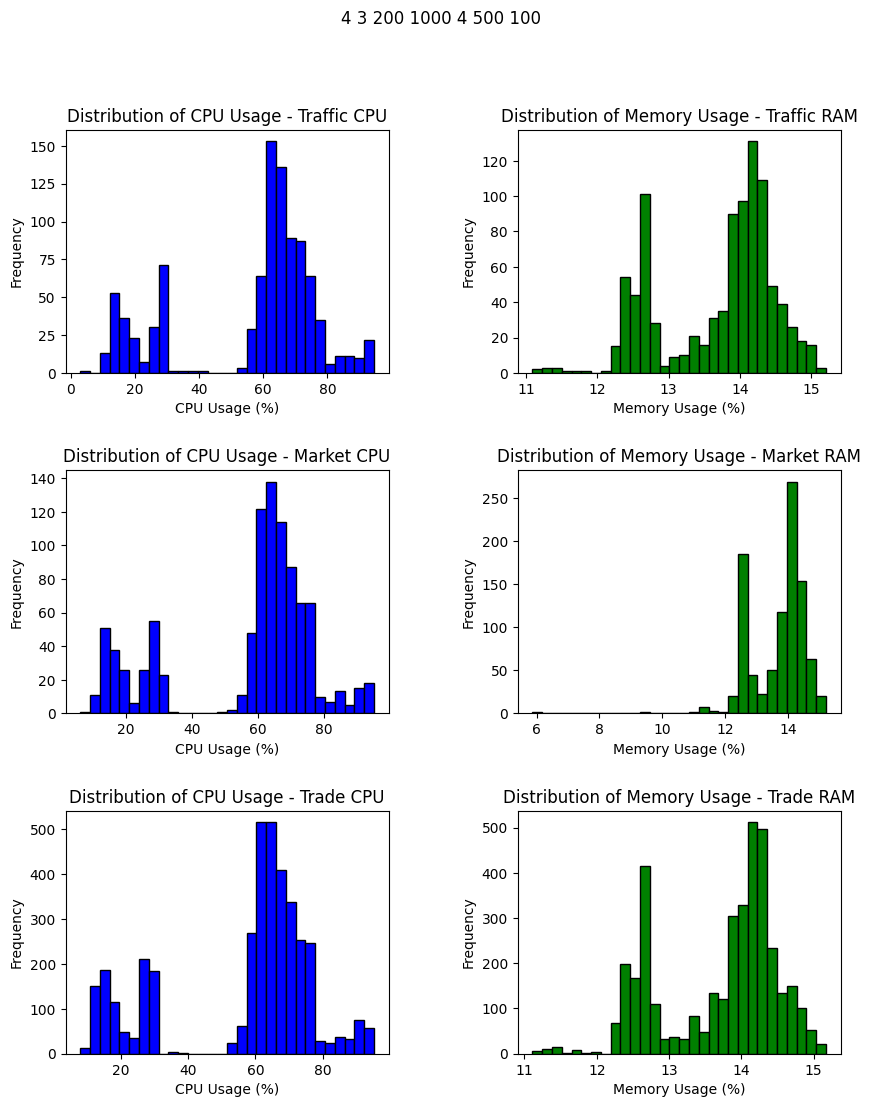

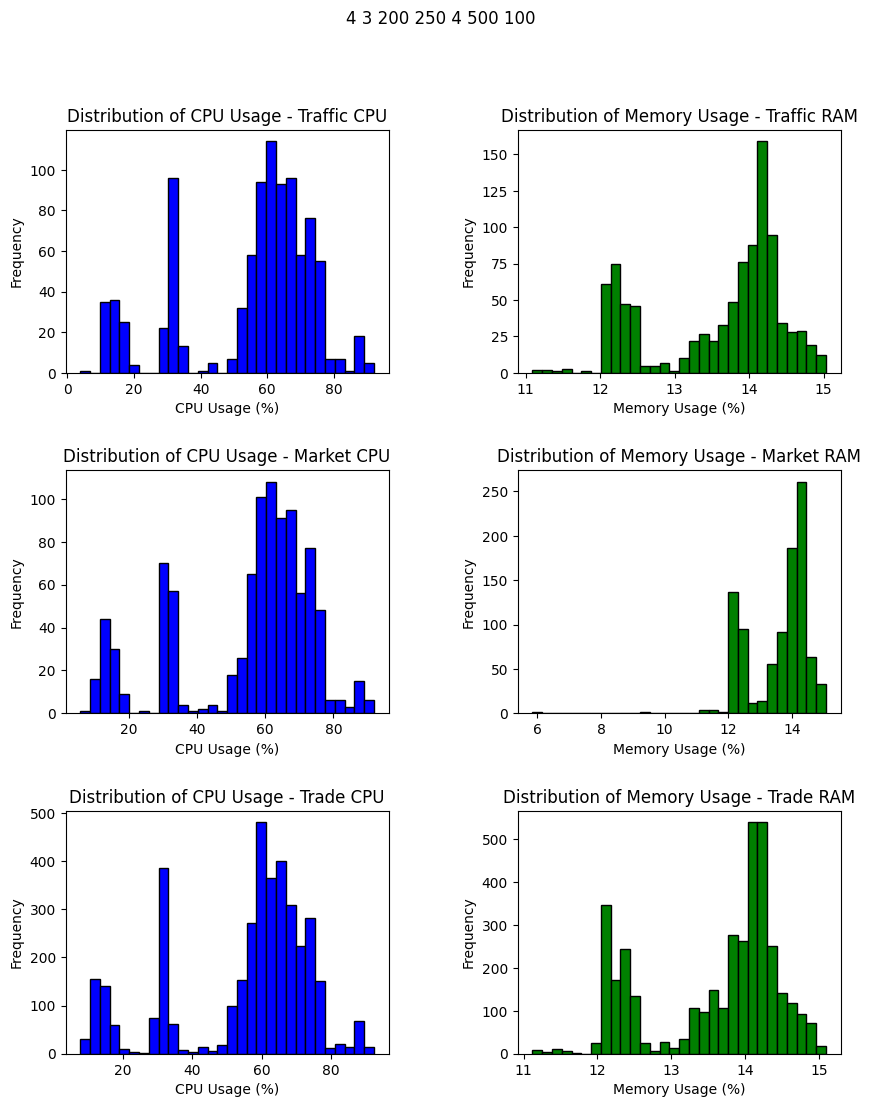

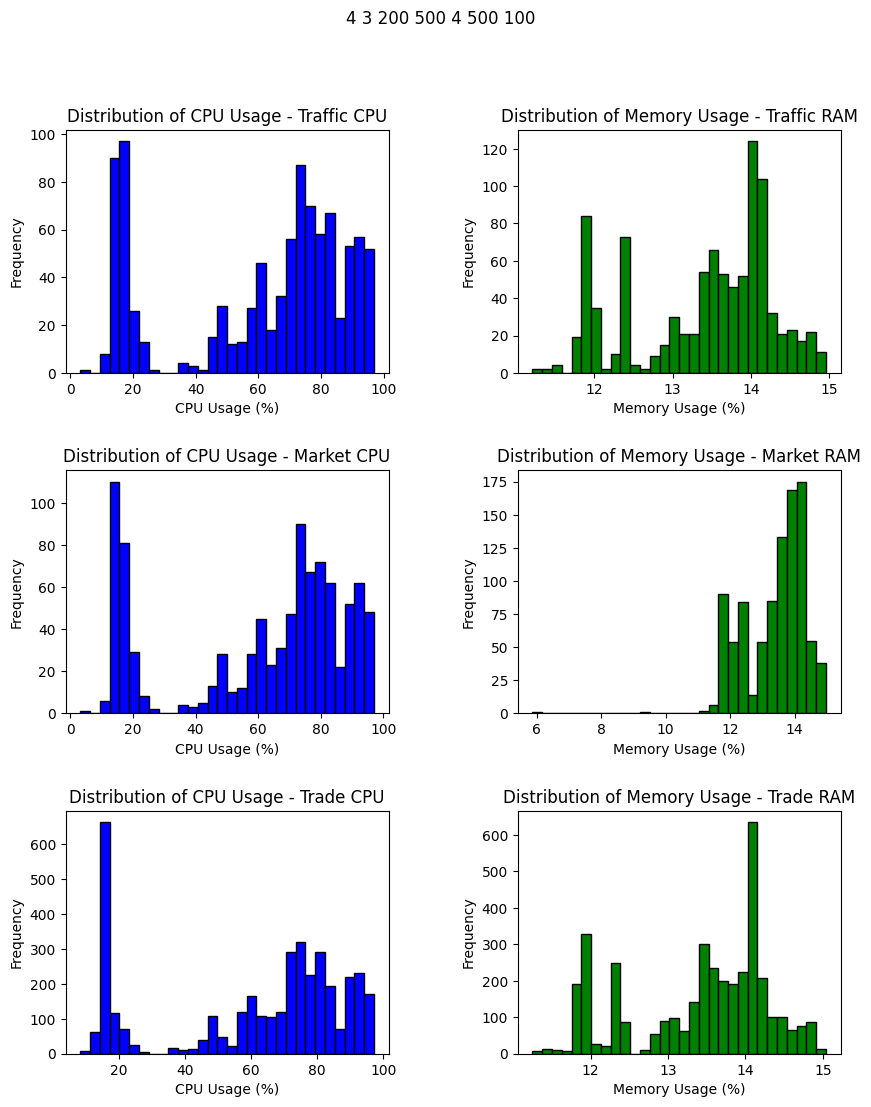

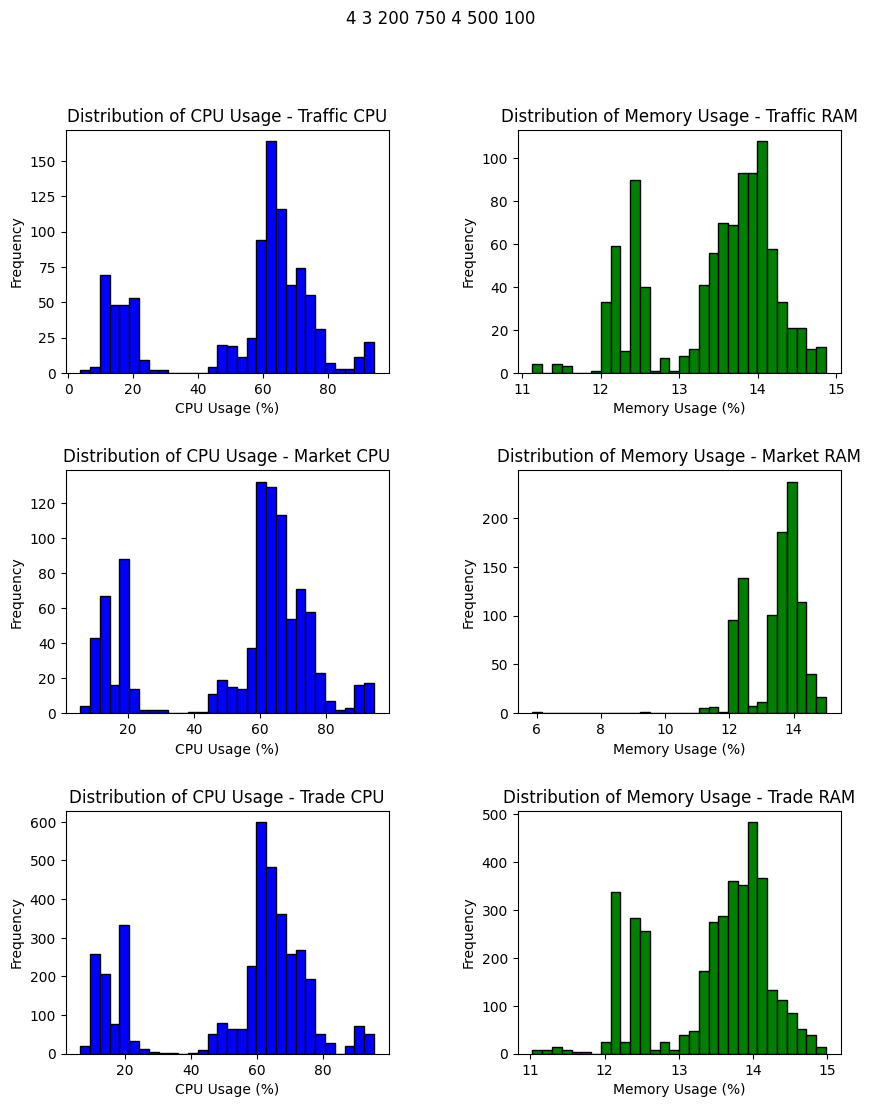

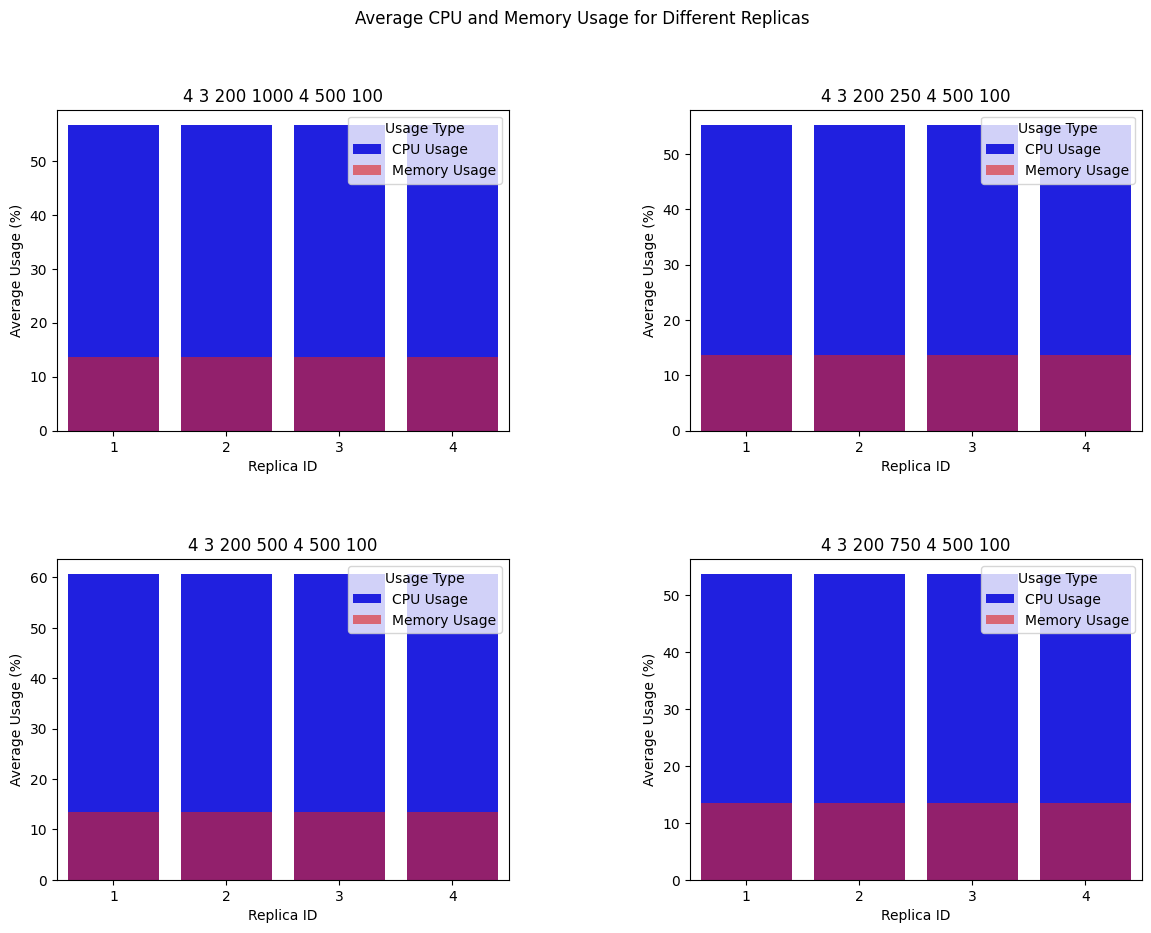

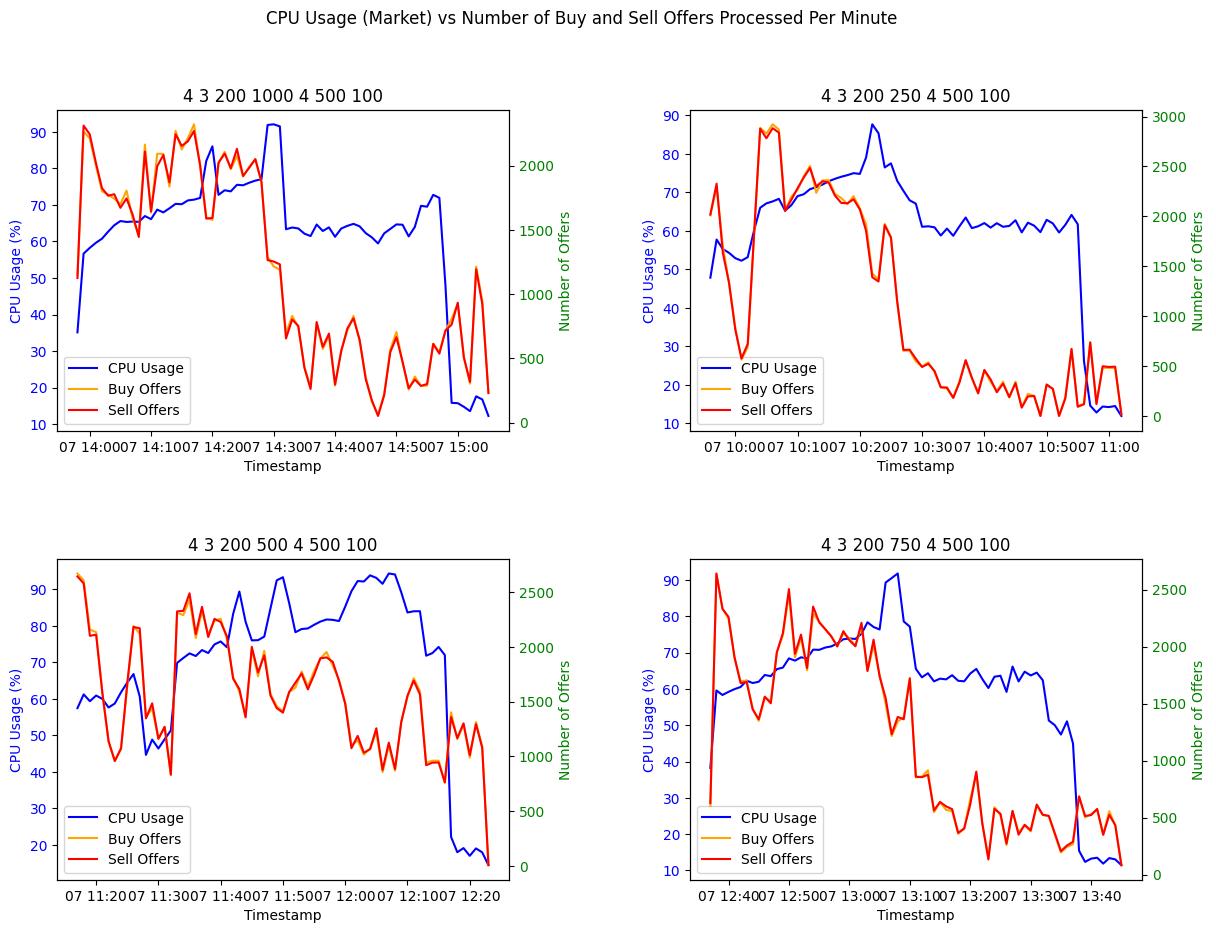

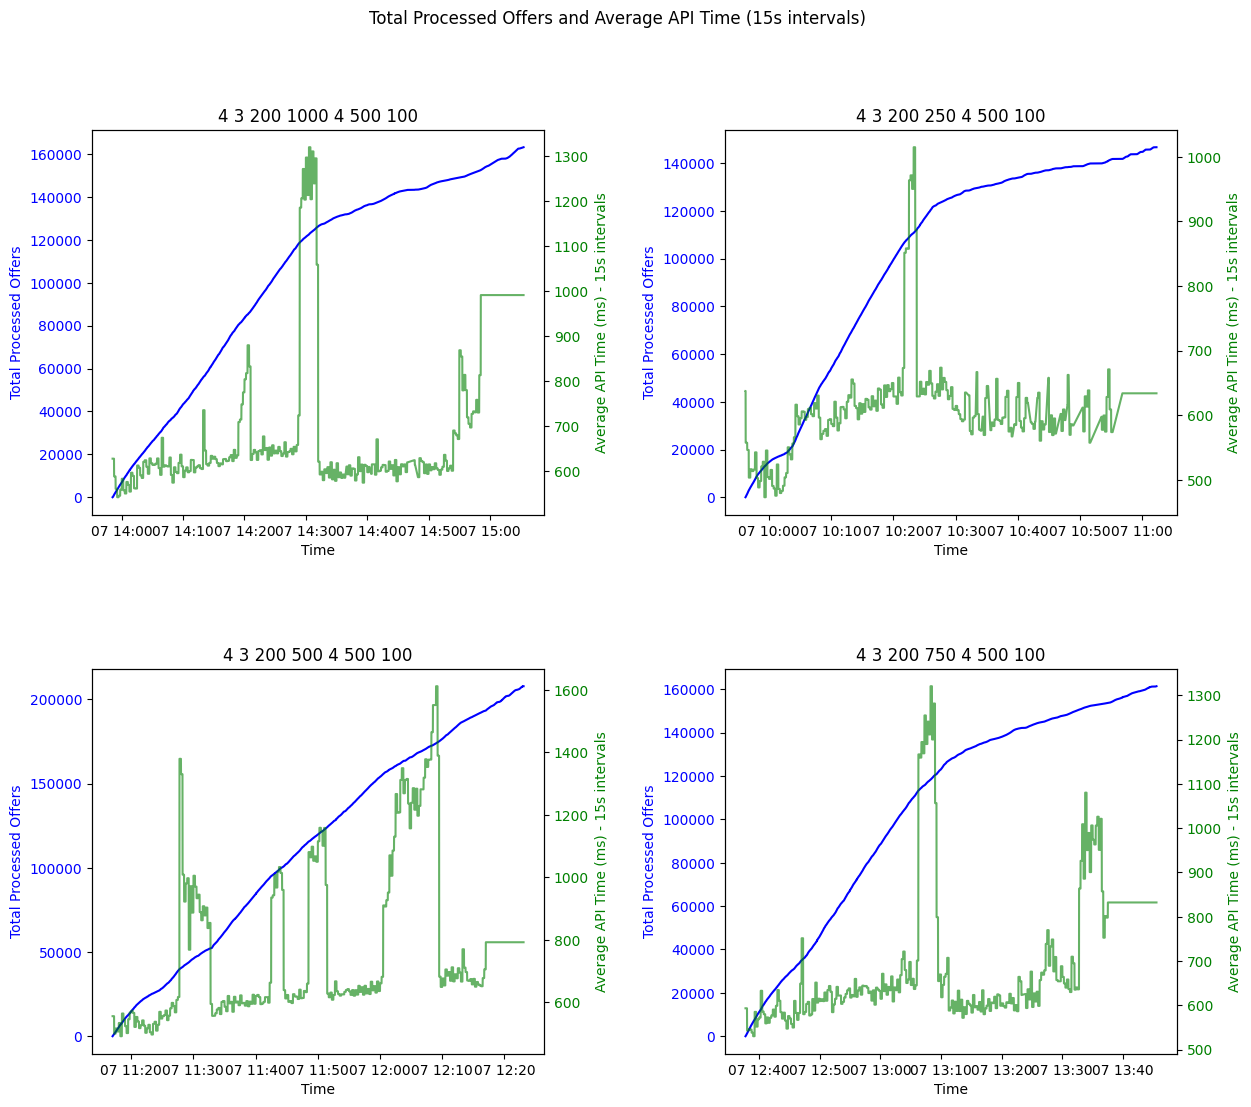

In [17]:
# Użycie funkcji do załadowania danych
base_dir = 'test3'  # ścieżka do katalogu test
all_data, test_paths = load_data_from_subdirectories(base_dir)
draw_all_subplots(all_data)